In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-07 19:00:41,146] A new study created in memory with name: no-name-2651df6a-6863-4e75-9c11-dcf2d0e6a671
[I 2025-06-07 19:02:43,832] Trial 0 finished with value: 3.994373106956482 and parameters: {'lr': 0.4361418595503969, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.29840954091698035}. Best is trial 0 with value: 3.994373106956482.


Cross Validation Accuracies:
[5.753762245178223, 3.784254312515259, 1.9892584085464478, 5.469647407531738, 2.974943161010742]
Mean Cross Validation Accuracy:
3.994373106956482
Standard Deviation of Cross Validation Accuracy:
1.4405385574762504


[I 2025-06-07 19:05:33,132] Trial 1 finished with value: 4.824939775466919 and parameters: {'lr': 0.595588392357328, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.24879023720904098}. Best is trial 0 with value: 3.994373106956482.


Cross Validation Accuracies:
[3.539503574371338, 5.126776218414307, 7.251036167144775, 3.1083905696868896, 5.098992347717285]
Mean Cross Validation Accuracy:
4.824939775466919
Standard Deviation of Cross Validation Accuracy:
1.4595232889756555


[I 2025-06-07 19:10:03,048] Trial 2 finished with value: 28.53622932434082 and parameters: {'lr': 0.2871622874846954, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3652117269165034}. Best is trial 0 with value: 3.994373106956482.


Cross Validation Accuracies:
[21.426795959472656, 32.674041748046875, 33.45838165283203, 22.478422164916992, 32.64350509643555]
Mean Cross Validation Accuracy:
28.53622932434082
Standard Deviation of Cross Validation Accuracy:
5.3936974297220495


[I 2025-06-07 19:15:15,274] Trial 3 finished with value: 0.08850806206464767 and parameters: {'lr': 0.07114155210897327, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3319120703997719}. Best is trial 3 with value: 0.08850806206464767.


Cross Validation Accuracies:
[0.09196207672357559, 0.09252646565437317, 0.08469376713037491, 0.10322917252779007, 0.07012882828712463]
Mean Cross Validation Accuracy:
0.08850806206464767
Standard Deviation of Cross Validation Accuracy:
0.010928256567600441


[I 2025-06-07 19:20:22,196] Trial 4 finished with value: 0.08354933261871338 and parameters: {'lr': 0.001997459408150699, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16754524862445547}. Best is trial 4 with value: 0.08354933261871338.


Cross Validation Accuracies:
[0.08017754554748535, 0.09161154180765152, 0.07190413028001785, 0.10500984638929367, 0.0690435990691185]
Mean Cross Validation Accuracy:
0.08354933261871338
Standard Deviation of Cross Validation Accuracy:
0.01328870843745296


[I 2025-06-07 19:26:28,868] Trial 5 finished with value: 0.19299690872430803 and parameters: {'lr': 0.3920695560652115, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.471941497336659}. Best is trial 4 with value: 0.08354933261871338.


Cross Validation Accuracies:
[0.2324276715517044, 0.23696057498455048, 0.11921436339616776, 0.20820362865924835, 0.16817830502986908]
Mean Cross Validation Accuracy:
0.19299690872430803
Standard Deviation of Cross Validation Accuracy:
0.04422365978480924


[I 2025-06-07 19:31:22,983] Trial 6 finished with value: 0.0892830640077591 and parameters: {'lr': 0.4695086085628779, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.48305764032673826}. Best is trial 4 with value: 0.08354933261871338.


Cross Validation Accuracies:
[0.09231489151716232, 0.09531877189874649, 0.08503545820713043, 0.09937119483947754, 0.07437500357627869]
Mean Cross Validation Accuracy:
0.0892830640077591
Standard Deviation of Cross Validation Accuracy:
0.008805504554949432


[I 2025-06-07 19:36:00,205] Trial 7 finished with value: 0.08933228552341461 and parameters: {'lr': 0.06783737939301655, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3342633497256513}. Best is trial 4 with value: 0.08354933261871338.


Cross Validation Accuracies:
[0.09121187776327133, 0.09251610934734344, 0.08351868391036987, 0.10660090297460556, 0.07281385362148285]
Mean Cross Validation Accuracy:
0.08933228552341461
Standard Deviation of Cross Validation Accuracy:
0.011122331644214502


[I 2025-06-07 19:40:56,042] Trial 8 finished with value: 0.09943505823612213 and parameters: {'lr': 0.00910724144886269, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.35370991828059406}. Best is trial 4 with value: 0.08354933261871338.


Cross Validation Accuracies:
[0.09477823972702026, 0.09457031637430191, 0.08254925906658173, 0.15008407831192017, 0.07519339770078659]
Mean Cross Validation Accuracy:
0.09943505823612213
Standard Deviation of Cross Validation Accuracy:
0.026394935975493285


[I 2025-06-07 19:46:59,086] Trial 9 finished with value: 0.08905752897262573 and parameters: {'lr': 0.024079580629728477, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3263367401907112}. Best is trial 4 with value: 0.08354933261871338.


Cross Validation Accuracies:
[0.09212666004896164, 0.09215404838323593, 0.0842556282877922, 0.10499900579452515, 0.07175230234861374]
Mean Cross Validation Accuracy:
0.08905752897262573
Standard Deviation of Cross Validation Accuracy:
0.010914832110322091


[I 2025-06-07 19:53:08,565] Trial 10 finished with value: 0.08089606910943985 and parameters: {'lr': 0.0010233896751483196, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12959657482614093}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.07305517047643661, 0.09142811596393585, 0.07207349687814713, 0.1011086106300354, 0.06681495159864426]
Mean Cross Validation Accuracy:
0.08089606910943985
Standard Deviation of Cross Validation Accuracy:
0.013092487832106944


[I 2025-06-07 19:59:53,455] Trial 11 finished with value: 0.08221558928489685 and parameters: {'lr': 0.001069642099824231, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1384865875311117}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08788484334945679, 0.09319052845239639, 0.06954102963209152, 0.09082312881946564, 0.06963841617107391]
Mean Cross Validation Accuracy:
0.08221558928489685
Standard Deviation of Cross Validation Accuracy:
0.01044518275709526


[I 2025-06-07 20:06:47,649] Trial 12 finished with value: 0.08337594270706176 and parameters: {'lr': 0.0011983957374822533, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10978319150859381}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08098508417606354, 0.0960337445139885, 0.07471596449613571, 0.09808696061372757, 0.06705795973539352]
Mean Cross Validation Accuracy:
0.08337594270706176
Standard Deviation of Cross Validation Accuracy:
0.012030145384211242


[I 2025-06-07 20:13:21,074] Trial 13 finished with value: 0.0869411513209343 and parameters: {'lr': 0.004461338861948536, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17695334950944774}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08854582905769348, 0.09240370988845825, 0.07659104466438293, 0.10497424751520157, 0.07219092547893524]
Mean Cross Validation Accuracy:
0.0869411513209343
Standard Deviation of Cross Validation Accuracy:
0.011681617741444396


[I 2025-06-07 20:19:48,815] Trial 14 finished with value: 0.08763986825942993 and parameters: {'lr': 0.0033047846742206965, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10330094172918339}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.07577359676361084, 0.09185894578695297, 0.09029868990182877, 0.10788819938898087, 0.07237990945577621]
Mean Cross Validation Accuracy:
0.08763986825942993
Standard Deviation of Cross Validation Accuracy:
0.012716442923577152


[I 2025-06-07 20:26:34,558] Trial 15 finished with value: 0.08912102580070495 and parameters: {'lr': 0.00866129309609664, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1891766224064597}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.0923522338271141, 0.09184371680021286, 0.0840659961104393, 0.10502520948648453, 0.07231797277927399]
Mean Cross Validation Accuracy:
0.08912102580070495
Standard Deviation of Cross Validation Accuracy:
0.010758185035685498


[I 2025-06-07 20:32:41,196] Trial 16 finished with value: 0.08653799816966057 and parameters: {'lr': 0.001044368191512692, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23354440781954613}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.091888926923275, 0.0918874591588974, 0.08310293406248093, 0.10337644070386887, 0.062434229999780655]
Mean Cross Validation Accuracy:
0.08653799816966057
Standard Deviation of Cross Validation Accuracy:
0.013664359654130957


[I 2025-06-07 20:39:54,921] Trial 17 finished with value: 0.08893295526504516 and parameters: {'lr': 0.011222107662389671, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12715438943184526}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08906438201665878, 0.0931972861289978, 0.08409132063388824, 0.10585399717092514, 0.07245779037475586]
Mean Cross Validation Accuracy:
0.08893295526504516
Standard Deviation of Cross Validation Accuracy:
0.010948935418137094


[I 2025-06-07 20:46:40,907] Trial 18 finished with value: 0.08352576419711114 and parameters: {'lr': 0.002827479653012023, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2243527932874543}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08124298602342606, 0.09128084778785706, 0.06157877668738365, 0.10543302446603775, 0.07809318602085114]
Mean Cross Validation Accuracy:
0.08352576419711114
Standard Deviation of Cross Validation Accuracy:
0.01453591150615269


[I 2025-06-07 20:53:42,579] Trial 19 finished with value: 0.08895501792430878 and parameters: {'lr': 0.02705857111667264, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1510116644424906}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09203208237886429, 0.09211613237857819, 0.08347685635089874, 0.10483418405056, 0.07231583446264267]
Mean Cross Validation Accuracy:
0.08895501792430878
Standard Deviation of Cross Validation Accuracy:
0.01075622208408634


[I 2025-06-07 20:59:49,409] Trial 20 finished with value: 0.09065627604722977 and parameters: {'lr': 0.005847990181102539, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.39138816746085475}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09827686846256256, 0.0930420532822609, 0.0833042711019516, 0.10517823696136475, 0.07347995042800903]
Mean Cross Validation Accuracy:
0.09065627604722977
Standard Deviation of Cross Validation Accuracy:
0.011168982487768325


[I 2025-06-07 21:06:14,372] Trial 21 finished with value: 0.08584872037172317 and parameters: {'lr': 0.0010299616292289906, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10488581089648057}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08532291650772095, 0.08888077735900879, 0.07674574851989746, 0.10395386070013046, 0.07434029877185822]
Mean Cross Validation Accuracy:
0.08584872037172317
Standard Deviation of Cross Validation Accuracy:
0.01051260015261911


[I 2025-06-07 21:13:13,918] Trial 22 finished with value: 0.09094521254301072 and parameters: {'lr': 0.0017077038132766785, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1397652429155536}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09500476717948914, 0.09386425465345383, 0.08249299228191376, 0.10553278774023056, 0.07783126085996628]
Mean Cross Validation Accuracy:
0.09094521254301072
Standard Deviation of Cross Validation Accuracy:
0.009810340431513671


[I 2025-06-07 21:20:10,052] Trial 23 finished with value: 0.08783521652221679 and parameters: {'lr': 0.0018453194341507232, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26887036068045755}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09233058989048004, 0.0919821709394455, 0.08238911628723145, 0.1049506813287735, 0.0675235241651535]
Mean Cross Validation Accuracy:
0.08783521652221679
Standard Deviation of Cross Validation Accuracy:
0.012430362845714802


[I 2025-06-07 21:27:08,432] Trial 24 finished with value: 0.08345188647508621 and parameters: {'lr': 0.0012589794579823653, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2059406379451161}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.07404118776321411, 0.09475924074649811, 0.07808656245470047, 0.10645020008087158, 0.06392224133014679]
Mean Cross Validation Accuracy:
0.08345188647508621
Standard Deviation of Cross Validation Accuracy:
0.015202195110614025


[I 2025-06-07 21:33:58,009] Trial 25 finished with value: 0.083290134370327 and parameters: {'lr': 0.0025447205558140266, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1267318789877695}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08570762723684311, 0.08566080778837204, 0.0837678536772728, 0.08946972340345383, 0.0718446597456932]
Mean Cross Validation Accuracy:
0.083290134370327
Standard Deviation of Cross Validation Accuracy:
0.006014628666050596


[I 2025-06-07 21:41:28,755] Trial 26 finished with value: 0.09042282402515411 and parameters: {'lr': 0.002838327542056892, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15534074675625228}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09330977499485016, 0.10149724781513214, 0.0823078453540802, 0.10500070452690125, 0.06999854743480682]
Mean Cross Validation Accuracy:
0.09042282402515411
Standard Deviation of Cross Validation Accuracy:
0.012856872879325456


[I 2025-06-07 21:48:13,473] Trial 27 finished with value: 0.08937387466430664 and parameters: {'lr': 0.014597047672106872, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20257130735749268}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09272407740354538, 0.09242583811283112, 0.08442701399326324, 0.10539231449365616, 0.0719001293182373]
Mean Cross Validation Accuracy:
0.08937387466430664
Standard Deviation of Cross Validation Accuracy:
0.011017549280757665


[I 2025-06-07 21:54:34,416] Trial 28 finished with value: 0.19721380174160003 and parameters: {'lr': 0.005118773434968244, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1301384562980802}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.1318642497062683, 0.1838272660970688, 0.17584827542304993, 0.32292139530181885, 0.1716078221797943]
Mean Cross Validation Accuracy:
0.19721380174160003
Standard Deviation of Cross Validation Accuracy:
0.065367138947135


[I 2025-06-07 22:00:32,151] Trial 29 finished with value: 0.10702131241559983 and parameters: {'lr': 0.145648354655143, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.27688295207588126}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09352543950080872, 0.10709643363952637, 0.11344210803508759, 0.1357782781124115, 0.08526430279016495]
Mean Cross Validation Accuracy:
0.10702131241559983
Standard Deviation of Cross Validation Accuracy:
0.017456811789365083


[I 2025-06-07 22:05:56,103] Trial 30 finished with value: 0.15200387239456176 and parameters: {'lr': 0.0019275402508379606, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4131449055618679}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.15825441479682922, 0.14214885234832764, 0.1670781821012497, 0.16043254733085632, 0.13210536539554596]
Mean Cross Validation Accuracy:
0.15200387239456176
Standard Deviation of Cross Validation Accuracy:
0.012887347714242577


[I 2025-06-07 22:11:56,034] Trial 31 finished with value: 0.08255568146705627 and parameters: {'lr': 0.0010424020955904778, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11414548173259992}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.07949338108301163, 0.09104087203741074, 0.07638071477413177, 0.09469970315694809, 0.07116373628377914]
Mean Cross Validation Accuracy:
0.08255568146705627
Standard Deviation of Cross Validation Accuracy:
0.008907974339651334


[I 2025-06-07 22:18:40,676] Trial 32 finished with value: 0.08948024064302444 and parameters: {'lr': 0.0028979343456374492, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1310220732522021}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09271068125963211, 0.09210297465324402, 0.08513184636831284, 0.10512134432792664, 0.07233435660600662]
Mean Cross Validation Accuracy:
0.08948024064302444
Standard Deviation of Cross Validation Accuracy:
0.010722392241723477


[I 2025-06-07 22:24:54,630] Trial 33 finished with value: 0.08958510905504227 and parameters: {'lr': 0.0015422368584416773, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17027271408397096}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08602169156074524, 0.09145025163888931, 0.07669603824615479, 0.11988428980112076, 0.07387327402830124]
Mean Cross Validation Accuracy:
0.08958510905504227
Standard Deviation of Cross Validation Accuracy:
0.01641467003143418


[I 2025-06-07 22:30:38,920] Trial 34 finished with value: 0.08839253336191177 and parameters: {'lr': 0.002331933296771986, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15421292182180604}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09192927181720734, 0.09100707620382309, 0.08306735008955002, 0.10354042798280716, 0.07241854071617126]
Mean Cross Validation Accuracy:
0.08839253336191177
Standard Deviation of Cross Validation Accuracy:
0.010318227391849056


[I 2025-06-07 22:37:22,937] Trial 35 finished with value: 13.164948272705079 and parameters: {'lr': 0.9612710449756893, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1912795973391374}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[5.955405235290527, 15.752182960510254, 5.572090148925781, 8.743967056274414, 29.801095962524414]
Mean Cross Validation Accuracy:
13.164948272705079
Standard Deviation of Cross Validation Accuracy:
9.084374205188492


[I 2025-06-07 22:43:35,390] Trial 36 finished with value: 0.08525021523237228 and parameters: {'lr': 0.0039823192793723506, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10012308470098014}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09222538024187088, 0.09170608222484589, 0.08462626487016678, 0.08549700677394867, 0.0721963420510292]
Mean Cross Validation Accuracy:
0.08525021523237228
Standard Deviation of Cross Validation Accuracy:
0.007227516457100901


[I 2025-06-07 22:50:38,156] Trial 37 finished with value: 0.12918453812599182 and parameters: {'lr': 0.0010040195927500752, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1277153258668035}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.10273238271474838, 0.14521828293800354, 0.13077478110790253, 0.15040439367294312, 0.11679285019636154]
Mean Cross Validation Accuracy:
0.12918453812599182
Standard Deviation of Cross Validation Accuracy:
0.017681417197258985


[I 2025-06-07 22:55:43,373] Trial 38 finished with value: 0.08907072842121125 and parameters: {'lr': 0.006092855814400131, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22428759513426033}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.0923062190413475, 0.09216101467609406, 0.08359573781490326, 0.10512416064739227, 0.07216650992631912]
Mean Cross Validation Accuracy:
0.08907072842121125
Standard Deviation of Cross Validation Accuracy:
0.010894577366680256


[I 2025-06-07 23:01:48,117] Trial 39 finished with value: 0.0890763208270073 and parameters: {'lr': 0.0481213724981113, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4497848305783321}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.09246903657913208, 0.09219349920749664, 0.08392928540706635, 0.10468374937772751, 0.07210603356361389]
Mean Cross Validation Accuracy:
0.0890763208270073
Standard Deviation of Cross Validation Accuracy:
0.01076384476488361


[I 2025-06-07 23:07:17,405] Trial 40 finished with value: 0.08154497295618057 and parameters: {'lr': 0.0014688539041839352, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2556940216360467}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.07956347614526749, 0.09025431424379349, 0.06819823384284973, 0.09795786440372467, 0.07175097614526749]
Mean Cross Validation Accuracy:
0.08154497295618057
Standard Deviation of Cross Validation Accuracy:
0.011164405756117384


[I 2025-06-07 23:13:09,036] Trial 41 finished with value: 0.08295769393444061 and parameters: {'lr': 0.0014932429990507832, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.30695326422712926}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.08527688682079315, 0.08855725824832916, 0.07670687139034271, 0.10095282644033432, 0.06329462677240372]
Mean Cross Validation Accuracy:
0.08295769393444061
Standard Deviation of Cross Validation Accuracy:
0.012540076257748443


[I 2025-06-07 23:18:40,511] Trial 42 finished with value: 0.08092281967401505 and parameters: {'lr': 0.0014854366504556595, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.308258398883193}. Best is trial 10 with value: 0.08089606910943985.


Cross Validation Accuracies:
[0.07128092646598816, 0.09258019924163818, 0.0687679648399353, 0.10251609236001968, 0.0694689154624939]
Mean Cross Validation Accuracy:
0.08092281967401505
Standard Deviation of Cross Validation Accuracy:
0.01395752446557082


[I 2025-06-07 23:23:55,470] Trial 43 finished with value: 0.08028381764888763 and parameters: {'lr': 0.0014894444806613416, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2567835194792307}. Best is trial 43 with value: 0.08028381764888763.


Cross Validation Accuracies:
[0.0767008438706398, 0.0869344100356102, 0.06887581944465637, 0.10218804329633713, 0.06671997159719467]
Mean Cross Validation Accuracy:
0.08028381764888763
Standard Deviation of Cross Validation Accuracy:
0.013045945915464301


[I 2025-06-07 23:29:31,436] Trial 44 finished with value: 0.07700417786836625 and parameters: {'lr': 0.002034299179242748, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2632321393286439}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.0659448578953743, 0.08868010342121124, 0.066320039331913, 0.09976042062044144, 0.06431546807289124]
Mean Cross Validation Accuracy:
0.07700417786836625
Standard Deviation of Cross Validation Accuracy:
0.014502665634371366


[I 2025-06-07 23:35:13,940] Trial 45 finished with value: 0.08431402295827865 and parameters: {'lr': 0.0021158511094489965, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2754742237455653}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08654487133026123, 0.0918986052274704, 0.07403060793876648, 0.09866449981927872, 0.07043153047561646]
Mean Cross Validation Accuracy:
0.08431402295827865
Standard Deviation of Cross Validation Accuracy:
0.01064810763271779


[I 2025-06-07 23:40:37,427] Trial 46 finished with value: 0.2573224902153015 and parameters: {'lr': 0.004120538517822904, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.255963223861521}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.19939693808555603, 0.23379890620708466, 0.23026074469089508, 0.4098191559314728, 0.21333670616149902]
Mean Cross Validation Accuracy:
0.2573224902153015
Standard Deviation of Cross Validation Accuracy:
0.07724124405825253


[I 2025-06-07 23:45:46,774] Trial 47 finished with value: 0.08381858319044114 and parameters: {'lr': 0.0014413983888826487, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3024417251680891}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.0793546587228775, 0.08415490388870239, 0.07036978751420975, 0.1163257285952568, 0.06888783723115921]
Mean Cross Validation Accuracy:
0.08381858319044114
Standard Deviation of Cross Validation Accuracy:
0.01720785585525201


[I 2025-06-07 23:51:18,173] Trial 48 finished with value: 0.08657857328653336 and parameters: {'lr': 0.007520516009891683, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35276475618621544}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08027976006269455, 0.09071283042430878, 0.08335354179143906, 0.10662902146577835, 0.07191771268844604]
Mean Cross Validation Accuracy:
0.08657857328653336
Standard Deviation of Cross Validation Accuracy:
0.011697258344753627


[I 2025-06-07 23:57:18,800] Trial 49 finished with value: 0.09584657698869706 and parameters: {'lr': 0.015703186749900146, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3197795256975454}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.09261264652013779, 0.10224824398756027, 0.10298266261816025, 0.11109872162342072, 0.07029061019420624]
Mean Cross Validation Accuracy:
0.09584657698869706
Standard Deviation of Cross Validation Accuracy:
0.014057728973845588


[I 2025-06-08 00:02:50,643] Trial 50 finished with value: 0.10409597605466843 and parameters: {'lr': 0.0038730912518704416, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24559689115536806}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08286014199256897, 0.09934110194444656, 0.11516512185335159, 0.11786270886659622, 0.10525080561637878]
Mean Cross Validation Accuracy:
0.10409597605466843
Standard Deviation of Cross Validation Accuracy:
0.01254553329644616


[I 2025-06-08 00:08:04,170] Trial 51 finished with value: 0.0803924098610878 and parameters: {'lr': 0.0015401133444619783, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2932697482172038}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.07795989513397217, 0.08742185682058334, 0.06973778456449509, 0.10033350437879562, 0.06650900840759277]
Mean Cross Validation Accuracy:
0.0803924098610878
Standard Deviation of Cross Validation Accuracy:
0.012322721932656388


[I 2025-06-08 00:13:18,381] Trial 52 finished with value: 0.08585471212863922 and parameters: {'lr': 0.0014697411146762148, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.285724335779041}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.09407924860715866, 0.09258381277322769, 0.06583122164011002, 0.11086259037256241, 0.06591668725013733]
Mean Cross Validation Accuracy:
0.08585471212863922
Standard Deviation of Cross Validation Accuracy:
0.017531587363580996


[I 2025-06-08 00:18:42,654] Trial 53 finished with value: 0.08505468368530274 and parameters: {'lr': 0.0021662539391547747, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.33760549942801343}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08534765988588333, 0.09787476062774658, 0.07418917864561081, 0.08974514901638031, 0.07811667025089264]
Mean Cross Validation Accuracy:
0.08505468368530274
Standard Deviation of Cross Validation Accuracy:
0.00839804623790502


[I 2025-06-08 00:24:13,697] Trial 54 finished with value: 0.08623175621032715 and parameters: {'lr': 0.0034762070632153915, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.25355129020233935}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.09319829195737839, 0.08461545407772064, 0.08217570930719376, 0.10144666582345963, 0.06972265988588333]
Mean Cross Validation Accuracy:
0.08623175621032715
Standard Deviation of Cross Validation Accuracy:
0.010692430082677973


[I 2025-06-08 00:29:59,996] Trial 55 finished with value: 0.08286247849464416 and parameters: {'lr': 0.0013428591477578395, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2939947561752511}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.07716695219278336, 0.09200108796358109, 0.07608737051486969, 0.1058410033583641, 0.06321597844362259]
Mean Cross Validation Accuracy:
0.08286247849464416
Standard Deviation of Cross Validation Accuracy:
0.014668693603630297


[I 2025-06-08 00:35:47,007] Trial 56 finished with value: 1.0448058128356934 and parameters: {'lr': 0.17359186985110292, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.32073824912164206}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.9405828714370728, 1.496109962463379, 1.0811982154846191, 0.5875852108001709, 1.118552803993225]
Mean Cross Validation Accuracy:
1.0448058128356934
Standard Deviation of Cross Validation Accuracy:
0.2933774229848046


[I 2025-06-08 00:41:04,258] Trial 57 finished with value: 0.07940087020397187 and parameters: {'lr': 0.001990076073764225, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.38688771392653654}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08142983168363571, 0.08831571787595749, 0.06668245047330856, 0.0988696813583374, 0.06170666962862015]
Mean Cross Validation Accuracy:
0.07940087020397187
Standard Deviation of Cross Validation Accuracy:
0.01369283561510265


[I 2025-06-08 00:46:45,223] Trial 58 finished with value: 0.08314470201730728 and parameters: {'lr': 0.001938001648316181, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.38729200762210125}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08497089147567749, 0.08898337185382843, 0.06805089861154556, 0.10145963728427887, 0.07225871086120605]
Mean Cross Validation Accuracy:
0.08314470201730728
Standard Deviation of Cross Validation Accuracy:
0.01199324469802582


[I 2025-06-08 00:52:12,238] Trial 59 finished with value: 0.33101176619529726 and parameters: {'lr': 0.0029198715908643107, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.44134935502209427}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.28490084409713745, 0.305532842874527, 0.3069038689136505, 0.47021061182022095, 0.2875106632709503]
Mean Cross Validation Accuracy:
0.33101176619529726
Standard Deviation of Cross Validation Accuracy:
0.07017869756645052


[I 2025-06-08 00:57:39,207] Trial 60 finished with value: 0.08415107503533363 and parameters: {'lr': 0.0022281414631487332, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.36961154207729036}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08753789961338043, 0.09210297465324402, 0.07853814959526062, 0.10460247844457626, 0.05797387287020683]
Mean Cross Validation Accuracy:
0.08415107503533363
Standard Deviation of Cross Validation Accuracy:
0.015554510823893527


[I 2025-06-08 01:03:54,334] Trial 61 finished with value: 0.07947548478841782 and parameters: {'lr': 0.0016247813860893958, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2641315897526837}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.07953484356403351, 0.08635049313306808, 0.06721634417772293, 0.09277275204658508, 0.07150299102067947]
Mean Cross Validation Accuracy:
0.07947548478841782
Standard Deviation of Cross Validation Accuracy:
0.009358779462384996


[I 2025-06-08 01:09:45,878] Trial 62 finished with value: 0.07798975259065628 and parameters: {'lr': 0.0017837248497609942, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21659900924239284}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08072959631681442, 0.08507008105516434, 0.06926846504211426, 0.0896947830915451, 0.06518583744764328]
Mean Cross Validation Accuracy:
0.07798975259065628
Standard Deviation of Cross Validation Accuracy:
0.009323589795027027


[I 2025-06-08 01:15:43,135] Trial 63 finished with value: 0.07964508384466171 and parameters: {'lr': 0.001248530738477964, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23298283417428514}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.07799535244703293, 0.08736903220415115, 0.07442589104175568, 0.09471331536769867, 0.06372182816267014]
Mean Cross Validation Accuracy:
0.07964508384466171
Standard Deviation of Cross Validation Accuracy:
0.010679163246286759


[I 2025-06-08 01:21:54,230] Trial 64 finished with value: 0.08017564862966538 and parameters: {'lr': 0.0017655570117295467, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23394636207560732}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.07620791345834732, 0.08376048505306244, 0.07040557265281677, 0.09840235114097595, 0.07210192084312439]
Mean Cross Validation Accuracy:
0.08017564862966538
Standard Deviation of Cross Validation Accuracy:
0.010212209594133896


[I 2025-06-08 01:28:01,085] Trial 65 finished with value: 0.08106183111667634 and parameters: {'lr': 0.002556939158416559, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2320426258796365}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.08572989702224731, 0.08746751397848129, 0.06846365332603455, 0.09786554425954819, 0.06578254699707031]
Mean Cross Validation Accuracy:
0.08106183111667634
Standard Deviation of Cross Validation Accuracy:
0.012143796724788873


[I 2025-06-08 01:33:50,544] Trial 66 finished with value: 0.0887690767645836 and parameters: {'lr': 0.005093157740331398, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21242307211189834}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.09188425540924072, 0.09266409277915955, 0.08323244005441666, 0.1035408228635788, 0.07252377271652222]
Mean Cross Validation Accuracy:
0.0887690767645836
Standard Deviation of Cross Validation Accuracy:
0.010369611566779523


[I 2025-06-08 01:40:19,215] Trial 67 finished with value: 0.07975762635469437 and parameters: {'lr': 0.0012167790649128788, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23972883190116018}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.07698243111371994, 0.09210627526044846, 0.06940244138240814, 0.0975097194314003, 0.062787264585495]
Mean Cross Validation Accuracy:
0.07975762635469437
Standard Deviation of Cross Validation Accuracy:
0.013195080002901882


[I 2025-06-08 01:46:11,949] Trial 68 finished with value: 0.08859770894050598 and parameters: {'lr': 0.0012048760805918734, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24016925630422756}. Best is trial 44 with value: 0.07700417786836625.


Cross Validation Accuracies:
[0.09163662046194077, 0.0903903990983963, 0.08407970517873764, 0.10656183958053589, 0.07031998038291931]
Mean Cross Validation Accuracy:
0.08859770894050598
Standard Deviation of Cross Validation Accuracy:
0.011744329951985676


[I 2025-06-08 01:51:33,866] Trial 69 finished with value: 0.07694577872753143 and parameters: {'lr': 0.0032174623282946384, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21218805203984709}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.07028887420892715, 0.08223233371973038, 0.07377159595489502, 0.09314417093992233, 0.06529191881418228]
Mean Cross Validation Accuracy:
0.07694577872753143
Standard Deviation of Cross Validation Accuracy:
0.009803446729348528


[I 2025-06-08 01:57:36,026] Trial 70 finished with value: 0.08879583179950715 and parameters: {'lr': 0.0030937761067359485, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1891442377306586}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.07891952246427536, 0.08811304718255997, 0.08268069475889206, 0.11870142817497253, 0.07556446641683578]
Mean Cross Validation Accuracy:
0.08879583179950715
Standard Deviation of Cross Validation Accuracy:
0.015522991376702053


[I 2025-06-08 02:03:40,409] Trial 71 finished with value: 0.08214564770460128 and parameters: {'lr': 0.0018542521101087778, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22299624633616794}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.07675039768218994, 0.09612420201301575, 0.06497060507535934, 0.1041354313492775, 0.06874760240316391]
Mean Cross Validation Accuracy:
0.08214564770460128
Standard Deviation of Cross Validation Accuracy:
0.015378875090935211


[I 2025-06-08 02:09:50,959] Trial 72 finished with value: 0.07738326489925385 and parameters: {'lr': 0.0012077458374734546, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.26786477885652704}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.07483755797147751, 0.09252946823835373, 0.0695158988237381, 0.08662335574626923, 0.06341004371643066]
Mean Cross Validation Accuracy:
0.07738326489925385
Standard Deviation of Cross Validation Accuracy:
0.01075559145191803


[I 2025-06-08 02:16:02,661] Trial 73 finished with value: 0.08231934607028961 and parameters: {'lr': 0.0011801363184022972, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2134738753810121}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.07824011147022247, 0.0876837894320488, 0.07455771416425705, 0.10247275233268738, 0.06864236295223236]
Mean Cross Validation Accuracy:
0.08231934607028961
Standard Deviation of Cross Validation Accuracy:
0.011822689952269969


[I 2025-06-08 02:22:10,663] Trial 74 finished with value: 0.07920069098472596 and parameters: {'lr': 0.0024297152715381785, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.49627575613111347}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.07653617113828659, 0.08325400948524475, 0.07054881751537323, 0.10113448649644852, 0.06452997028827667]
Mean Cross Validation Accuracy:
0.07920069098472596
Standard Deviation of Cross Validation Accuracy:
0.012607183687974827


[I 2025-06-08 02:28:26,649] Trial 75 finished with value: 0.08382691442966461 and parameters: {'lr': 0.003458572664727195, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4875888625611282}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.08397945761680603, 0.08939673006534576, 0.07837440073490143, 0.1005716472864151, 0.06681233644485474]
Mean Cross Validation Accuracy:
0.08382691442966461
Standard Deviation of Cross Validation Accuracy:
0.01123083223698153


[I 2025-06-08 02:34:39,818] Trial 76 finished with value: 0.11434626430273057 and parameters: {'lr': 0.002473085085124375, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2619324225548449}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.12230841815471649, 0.1213701143860817, 0.08479011803865433, 0.13897062838077545, 0.10429204255342484]
Mean Cross Validation Accuracy:
0.11434626430273057
Standard Deviation of Cross Validation Accuracy:
0.018405123347437113


[I 2025-06-08 02:40:09,388] Trial 77 finished with value: 0.2365506708621979 and parameters: {'lr': 0.0045911681760186195, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.47242638821099}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.23304256796836853, 0.2363489717245102, 0.1756500005722046, 0.3835112452507019, 0.15420056879520416]
Mean Cross Validation Accuracy:
0.2365506708621979
Standard Deviation of Cross Validation Accuracy:
0.08012513818430471


[I 2025-06-08 02:46:26,358] Trial 78 finished with value: 0.08553233295679093 and parameters: {'lr': 0.002551571069479417, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.26759267425132743}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.08040277659893036, 0.09240692108869553, 0.0818687453866005, 0.10582080483436584, 0.0671624168753624]
Mean Cross Validation Accuracy:
0.08553233295679093
Standard Deviation of Cross Validation Accuracy:
0.01293112595454951


[I 2025-06-08 02:52:29,313] Trial 79 finished with value: 0.08210157155990601 and parameters: {'lr': 0.0017847785499000295, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4339744733869147}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.08373581618070602, 0.09182464331388474, 0.07382480800151825, 0.09543439745903015, 0.06568819284439087]
Mean Cross Validation Accuracy:
0.08210157155990601
Standard Deviation of Cross Validation Accuracy:
0.011071376988707134


[I 2025-06-08 02:59:07,731] Trial 80 finished with value: 0.24358435869216918 and parameters: {'lr': 0.037116524353882116, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2800529158666731}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.2487095594406128, 0.24145258963108063, 0.22581656277179718, 0.21074843406677246, 0.2911946475505829]
Mean Cross Validation Accuracy:
0.24358435869216918
Standard Deviation of Cross Validation Accuracy:
0.027171471233983543


[I 2025-06-08 03:05:02,166] Trial 81 finished with value: 0.08373316079378128 and parameters: {'lr': 0.0011874251446256057, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1956695329105847}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.08053762465715408, 0.08799481391906738, 0.07064198702573776, 0.1133398786187172, 0.06615149974822998]
Mean Cross Validation Accuracy:
0.08373316079378128
Standard Deviation of Cross Validation Accuracy:
0.016645867443133722


[I 2025-06-08 03:11:03,906] Trial 82 finished with value: 0.08266302645206451 and parameters: {'lr': 0.002017751695353776, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2386993639516113}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.08981283754110336, 0.0852123498916626, 0.07266777753829956, 0.09538521617650986, 0.07023695111274719]
Mean Cross Validation Accuracy:
0.08266302645206451
Standard Deviation of Cross Validation Accuracy:
0.009734323902356231


[I 2025-06-08 03:16:45,243] Trial 83 finished with value: 0.08104304447770119 and parameters: {'lr': 0.0012741928756102108, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2162199053766258}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.0822785273194313, 0.08459408581256866, 0.0736759603023529, 0.10341457277536392, 0.06125207617878914]
Mean Cross Validation Accuracy:
0.08104304447770119
Standard Deviation of Cross Validation Accuracy:
0.013860576800714177


[I 2025-06-08 03:22:25,440] Trial 84 finished with value: 0.07807342112064361 and parameters: {'lr': 0.001008184838905753, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.180547648981731}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.0774344950914383, 0.08501166105270386, 0.06915073096752167, 0.09702067077159882, 0.061749547719955444]
Mean Cross Validation Accuracy:
0.07807342112064361
Standard Deviation of Cross Validation Accuracy:
0.012277042897469795


[I 2025-06-08 03:28:06,501] Trial 85 finished with value: 0.07865302115678788 and parameters: {'lr': 0.0017361347819484206, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19911898379980528}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.08070249855518341, 0.08707767724990845, 0.06999383121728897, 0.09221577644348145, 0.06327532231807709]
Mean Cross Validation Accuracy:
0.07865302115678788
Standard Deviation of Cross Validation Accuracy:
0.010682497000636398


[I 2025-06-08 03:34:42,540] Trial 86 finished with value: 0.08865989744663239 and parameters: {'lr': 0.006257938053418889, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17863558155349327}. Best is trial 69 with value: 0.07694577872753143.


Cross Validation Accuracies:
[0.0900326669216156, 0.09240133315324783, 0.08408253639936447, 0.10470341145992279, 0.07207953929901123]
Mean Cross Validation Accuracy:
0.08865989744663239
Standard Deviation of Cross Validation Accuracy:
0.010668998917736015


[I 2025-06-08 03:42:08,111] Trial 87 finished with value: 0.07665499001741409 and parameters: {'lr': 0.0010366318428396447, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17036707758239444}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.06945224851369858, 0.08368269354104996, 0.0719289630651474, 0.09416715800762177, 0.06404388695955276]
Mean Cross Validation Accuracy:
0.07665499001741409
Standard Deviation of Cross Validation Accuracy:
0.010856513075497811


[I 2025-06-08 03:49:41,367] Trial 88 finished with value: 0.09986641556024552 and parameters: {'lr': 0.0010929393678708584, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17932559384717545}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.10194661468267441, 0.10877645015716553, 0.0944717526435852, 0.12044254690408707, 0.07369471341371536]
Mean Cross Validation Accuracy:
0.09986641556024552
Standard Deviation of Cross Validation Accuracy:
0.0156278821803683


[I 2025-06-08 03:56:38,295] Trial 89 finished with value: 0.08178841024637222 and parameters: {'lr': 0.002251474848218301, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.16693260718814135}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.0760037824511528, 0.09410178661346436, 0.06678321957588196, 0.09897865355014801, 0.07307460904121399]
Mean Cross Validation Accuracy:
0.08178841024637222
Standard Deviation of Cross Validation Accuracy:
0.012503373141921995


[I 2025-06-08 04:03:42,904] Trial 90 finished with value: 0.0833513081073761 and parameters: {'lr': 0.003284463648067821, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.16572476787455068}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.07334842532873154, 0.09158305078744888, 0.07587336748838425, 0.10479611158370972, 0.07115558534860611]
Mean Cross Validation Accuracy:
0.0833513081073761
Standard Deviation of Cross Validation Accuracy:
0.01290235712637621


[I 2025-06-08 04:10:36,714] Trial 91 finished with value: 0.08276405036449433 and parameters: {'lr': 0.0017605930078609842, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.20348344010616268}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.08851580321788788, 0.0852825790643692, 0.07398278266191483, 0.1000090166926384, 0.06603007018566132]
Mean Cross Validation Accuracy:
0.08276405036449433
Standard Deviation of Cross Validation Accuracy:
0.011780927522460861


[I 2025-06-08 04:16:50,673] Trial 92 finished with value: 0.08039889931678772 and parameters: {'lr': 0.001001960086206772, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19535906782800988}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.08451204746961594, 0.09154169261455536, 0.0734095573425293, 0.08741747587919235, 0.06511372327804565]
Mean Cross Validation Accuracy:
0.08039889931678772
Standard Deviation of Cross Validation Accuracy:
0.009724482042090369


[I 2025-06-08 04:22:22,992] Trial 93 finished with value: 0.08167904615402222 and parameters: {'lr': 0.001666223069258341, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14251614316001704}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.07928015291690826, 0.09682261943817139, 0.0729660838842392, 0.09036698192358017, 0.06895939260721207]
Mean Cross Validation Accuracy:
0.08167904615402222
Standard Deviation of Cross Validation Accuracy:
0.010471561740036436


[I 2025-06-08 04:27:53,871] Trial 94 finished with value: 0.09140056222677231 and parameters: {'lr': 0.002680623711239578, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.18480660057506068}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.0940493792295456, 0.10226774960756302, 0.07774025946855545, 0.10699427872896194, 0.07595114409923553]
Mean Cross Validation Accuracy:
0.09140056222677231
Standard Deviation of Cross Validation Accuracy:
0.012598129856130775


[I 2025-06-08 04:32:47,967] Trial 95 finished with value: 0.08243229538202286 and parameters: {'lr': 0.0016514784014095675, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.409772717203512}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.07910868525505066, 0.09259402006864548, 0.07401219010353088, 0.10344051569700241, 0.06300606578588486]
Mean Cross Validation Accuracy:
0.08243229538202286
Standard Deviation of Cross Validation Accuracy:
0.014169890069498096


[I 2025-06-08 04:38:02,333] Trial 96 finished with value: 0.41856902837753296 and parameters: {'lr': 0.0013360004047678548, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15407665862006872}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.38173121213912964, 0.38047802448272705, 0.38006260991096497, 0.5603169202804565, 0.3902563750743866]
Mean Cross Validation Accuracy:
0.41856902837753296
Standard Deviation of Cross Validation Accuracy:
0.07097149391415966


[I 2025-06-08 04:42:56,931] Trial 97 finished with value: 0.08312854766845704 and parameters: {'lr': 0.002241038711325939, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.494571502972762}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.08725418895483017, 0.0835571438074112, 0.0739029124379158, 0.10306952148675919, 0.0678589716553688]
Mean Cross Validation Accuracy:
0.08312854766845704
Standard Deviation of Cross Validation Accuracy:
0.012108834333021885


[I 2025-06-08 04:48:06,932] Trial 98 finished with value: 0.08600687980651855 and parameters: {'lr': 0.0020017129857981745, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2479219240251475}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.08699134737253189, 0.10062482208013535, 0.07049746811389923, 0.09932389855384827, 0.07259686291217804]
Mean Cross Validation Accuracy:
0.08600687980651855
Standard Deviation of Cross Validation Accuracy:
0.012746503875005971


[I 2025-06-08 04:53:10,917] Trial 99 finished with value: 0.08478323072195053 and parameters: {'lr': 0.0037192460824284155, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2061408505284501}. Best is trial 87 with value: 0.07665499001741409.


Cross Validation Accuracies:
[0.08622974157333374, 0.08406785130500793, 0.08171552419662476, 0.10307195037603378, 0.06883108615875244]
Mean Cross Validation Accuracy:
0.08478323072195053
Standard Deviation of Cross Validation Accuracy:
0.010963240099803545
Number of finished trials: 100
Best trial: {'lr': 0.0010366318428396447, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17036707758239444}
Best hyperparameters:  {'lr': 0.0010366318428396447, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17036707758239444}
Fold 1:
Epoch 1/100
19/19 [==============================] - 17s 473ms/step - loss: 0.1781 - val_loss: 0.1208
Epoch 2/100
19/19 [==============================] - 4s 192ms/step - loss: 0.1094 - val_loss: 0.0940
Epoch 3/100
19/19 [==============================] - 3s 170ms/step - loss: 0.0915 - val_loss: 0.0802
Epoch 4/100
19/19 [==============================] - 4s 2

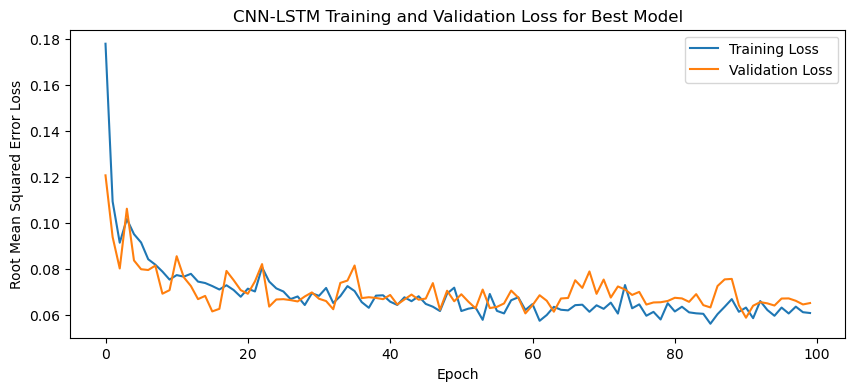

1/1 - 3s - loss: 0.0838 - 3s/epoch - 3s/step
Test Loss: 0.08384797722101212
Fold 2:
Epoch 1/100
19/19 [==============================] - 19s 440ms/step - loss: 0.1991 - val_loss: 0.1203
Epoch 2/100
19/19 [==============================] - 4s 193ms/step - loss: 0.1129 - val_loss: 0.0897
Epoch 3/100
19/19 [==============================] - 3s 167ms/step - loss: 0.0896 - val_loss: 0.0572
Epoch 4/100
19/19 [==============================] - 3s 168ms/step - loss: 0.0902 - val_loss: 0.0663
Epoch 5/100
19/19 [==============================] - 4s 191ms/step - loss: 0.0834 - val_loss: 0.0633
Epoch 6/100
19/19 [==============================] - 4s 191ms/step - loss: 0.0861 - val_loss: 0.0857
Epoch 7/100
19/19 [==============================] - 4s 242ms/step - loss: 0.0825 - val_loss: 0.0875
Epoch 8/100
19/19 [==============================] - 4s 211ms/step - loss: 0.0800 - val_loss: 0.0701
Epoch 9/100
19/19 [==============================] - 4s 193ms/step - loss: 0.0798 - val_loss: 0.0737
Epoch 

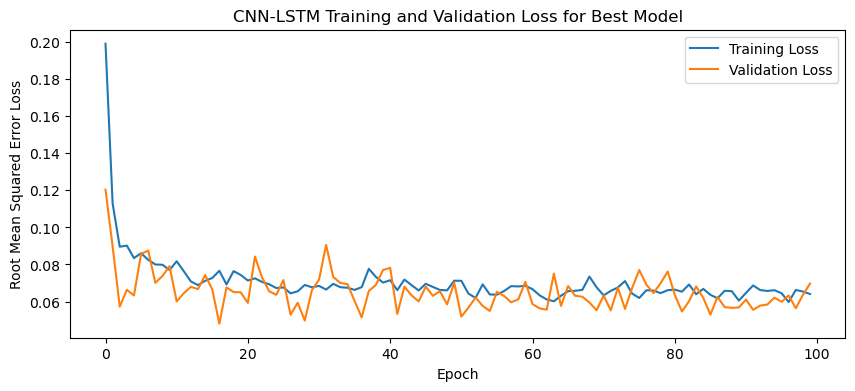

1/1 - 4s - loss: 0.0979 - 4s/epoch - 4s/step
Test Loss: 0.09790901839733124
Fold 3:
Epoch 1/100
19/19 [==============================] - 27s 429ms/step - loss: 0.1817 - val_loss: 0.1112
Epoch 2/100
19/19 [==============================] - 2s 123ms/step - loss: 0.1051 - val_loss: 0.0819
Epoch 3/100
19/19 [==============================] - 2s 129ms/step - loss: 0.0970 - val_loss: 0.0915
Epoch 4/100
19/19 [==============================] - 3s 141ms/step - loss: 0.0965 - val_loss: 0.0752
Epoch 5/100
19/19 [==============================] - 2s 125ms/step - loss: 0.0983 - val_loss: 0.0877
Epoch 6/100
19/19 [==============================] - 2s 91ms/step - loss: 0.0856 - val_loss: 0.0751
Epoch 7/100
19/19 [==============================] - 2s 100ms/step - loss: 0.0818 - val_loss: 0.0725
Epoch 8/100
19/19 [==============================] - 2s 97ms/step - loss: 0.0830 - val_loss: 0.0597
Epoch 9/100
19/19 [==============================] - 2s 98ms/step - loss: 0.0800 - val_loss: 0.0667
Epoch 10/

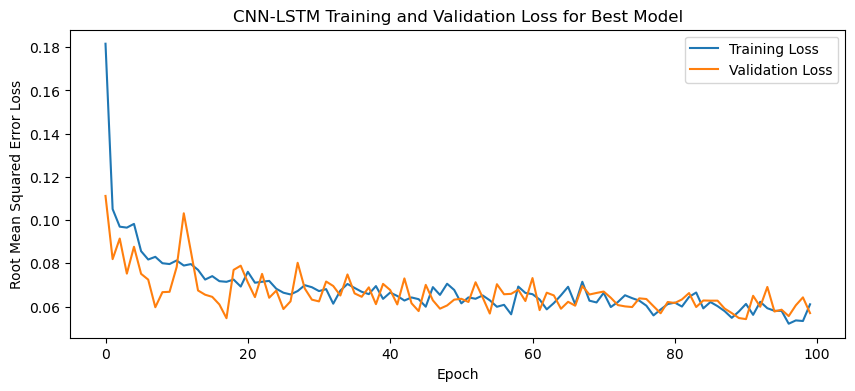

1/1 - 5s - loss: 0.0748 - 5s/epoch - 5s/step
Test Loss: 0.07480604201555252
Fold 4:
Epoch 1/100
20/20 [==============================] - 24s 419ms/step - loss: 0.2524 - val_loss: 0.1006
Epoch 2/100
20/20 [==============================] - 2s 119ms/step - loss: 0.1461 - val_loss: 0.0932
Epoch 3/100
20/20 [==============================] - 3s 145ms/step - loss: 0.1324 - val_loss: 0.1122
Epoch 4/100
20/20 [==============================] - 3s 158ms/step - loss: 0.1340 - val_loss: 0.1207
Epoch 5/100
20/20 [==============================] - 2s 124ms/step - loss: 0.1306 - val_loss: 0.0967
Epoch 6/100
20/20 [==============================] - 2s 120ms/step - loss: 0.1224 - val_loss: 0.1265
Epoch 7/100
20/20 [==============================] - 3s 128ms/step - loss: 0.1248 - val_loss: 0.1031
Epoch 8/100
20/20 [==============================] - 3s 158ms/step - loss: 0.1242 - val_loss: 0.0971
Epoch 9/100
20/20 [==============================] - 3s 134ms/step - loss: 0.1215 - val_loss: 0.0816
Epoch 

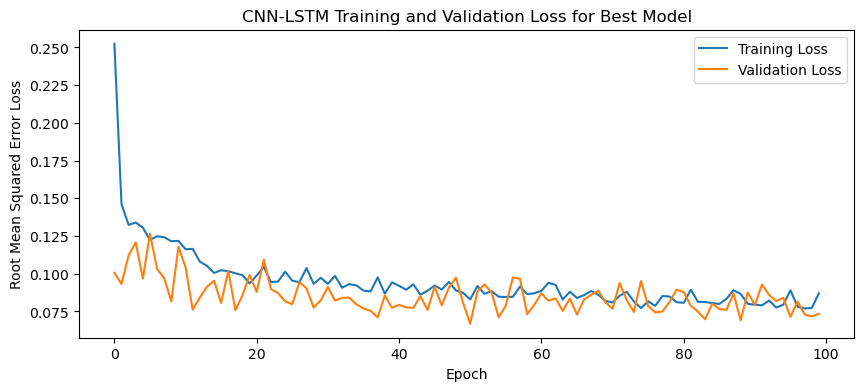

1/1 - 5s - loss: 0.0945 - 5s/epoch - 5s/step
Test Loss: 0.09454568475484848
Fold 5:
Epoch 1/100
19/19 [==============================] - 24s 422ms/step - loss: 0.2042 - val_loss: 0.1619
Epoch 2/100
19/19 [==============================] - 3s 143ms/step - loss: 0.1201 - val_loss: 0.1066
Epoch 3/100
19/19 [==============================] - 3s 159ms/step - loss: 0.0957 - val_loss: 0.1234
Epoch 4/100
19/19 [==============================] - 3s 183ms/step - loss: 0.1039 - val_loss: 0.0974
Epoch 5/100
19/19 [==============================] - 3s 186ms/step - loss: 0.0958 - val_loss: 0.1056
Epoch 6/100
19/19 [==============================] - 3s 173ms/step - loss: 0.0892 - val_loss: 0.1041
Epoch 7/100
19/19 [==============================] - 3s 159ms/step - loss: 0.0805 - val_loss: 0.0896
Epoch 8/100
19/19 [==============================] - 3s 135ms/step - loss: 0.0778 - val_loss: 0.0719
Epoch 9/100
19/19 [==============================] - 3s 149ms/step - loss: 0.0806 - val_loss: 0.0892
Epoch 

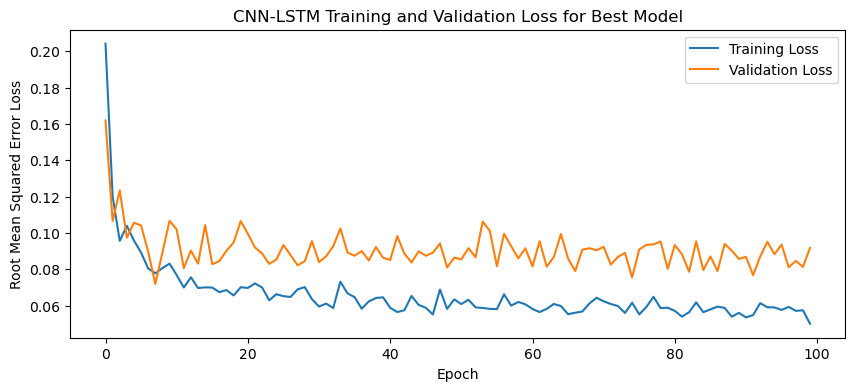

1/1 - 2s - loss: 0.0656 - 2s/epoch - 2s/step
Test Loss: 0.06564857065677643


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

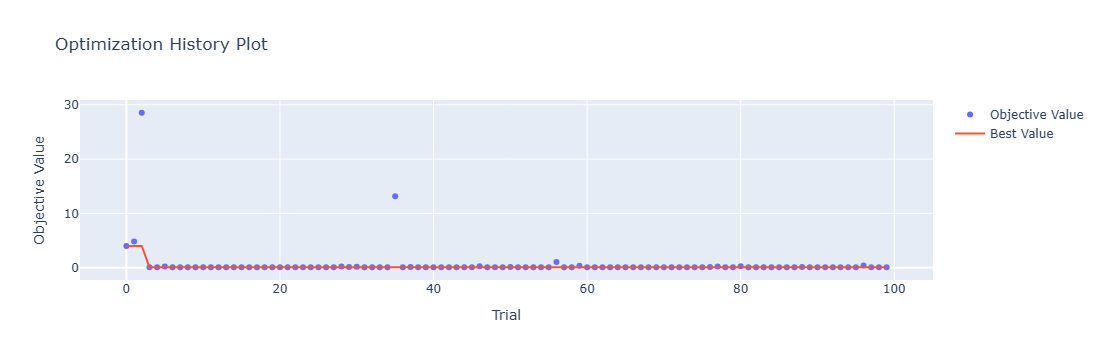

In [4]:
optuna.visualization.plot_optimization_history(study)

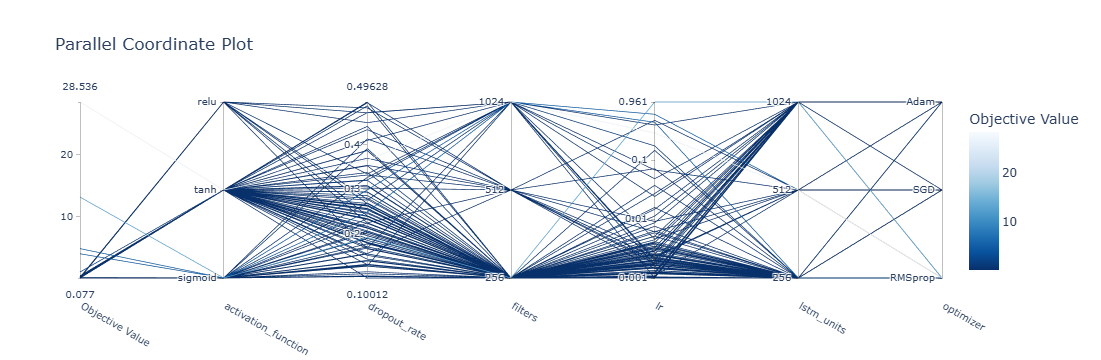

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

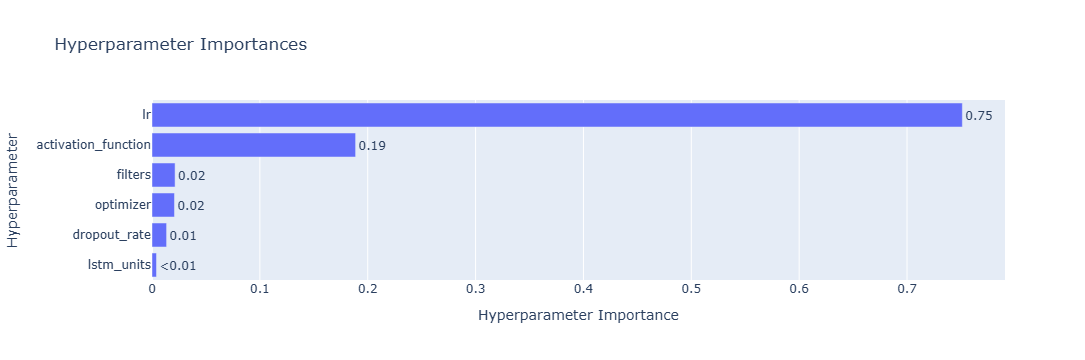

In [6]:
optuna.visualization.plot_param_importances(study)

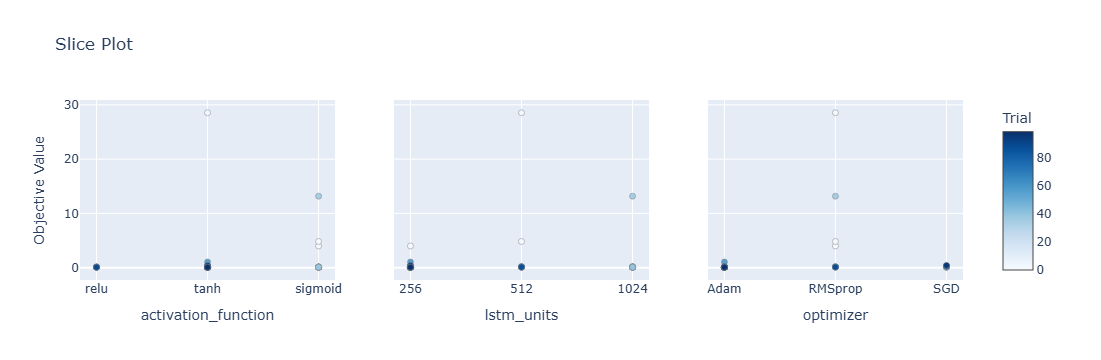

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

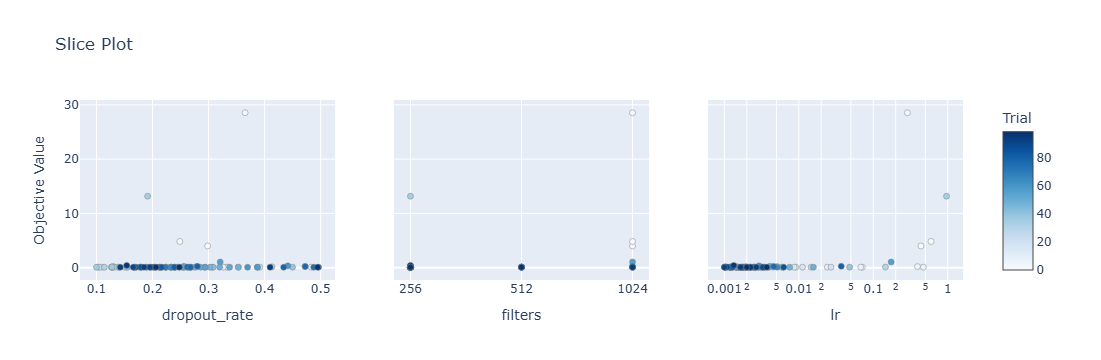

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 42s 633ms/step - loss: 0.1888 - accuracy: 0.2632 - mae: 0.1621 - rmse: 0.1888 - mape: 37.8063 - pearson: 0.1908 - val_loss: 0.1038 - val_accuracy: 0.3333 - val_mae: 0.0882 - val_rmse: 0.1038 - val_mape: 21.2370 - val_pearson: 0.3821
Epoch 2/100
19/19 [==============================] - 3s 143ms/step - loss: 0.1143 - accuracy: 0.3684 - mae: 0.0973 - rmse: 0.1143 - mape: 23.7828 - pearson: 0.2590 - val_loss: 0.0938 - val_accuracy: 0.0000e+00 - val_mae: 0.0744 - val_rmse: 0.0938 - val_mape: 18.8103 - val_pearson: 0.2187
Epoch 3/100
19/19 [==============================] - 3s 147ms/step - loss: 0.0964 - ac

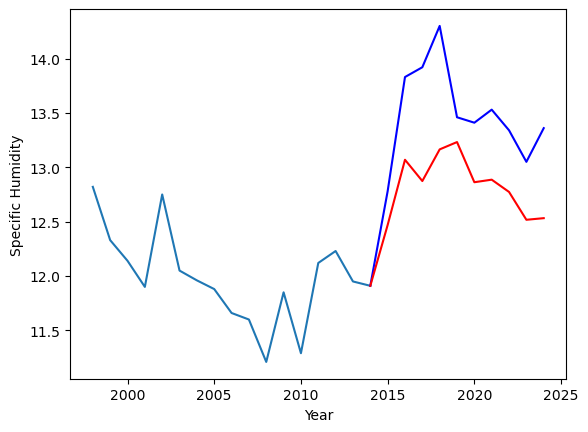

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		9.69		-0.02
10.79		10.28		-0.51
10.20		10.16		-0.04
10.87		10.34		-0.53
10.99		10.48		-0.51
10.80		10.08		-0.72
11.01		10.05		-0.96
10.57		10.03		-0.54
10.05		9.75		-0.30
10.24		9.76		-0.48


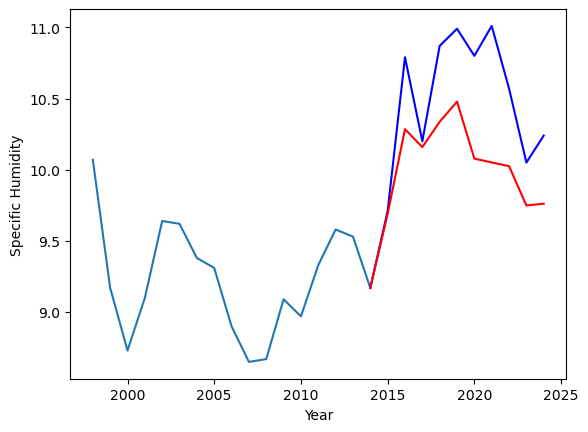

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78  12.469247
1                1    9.71   9.689943


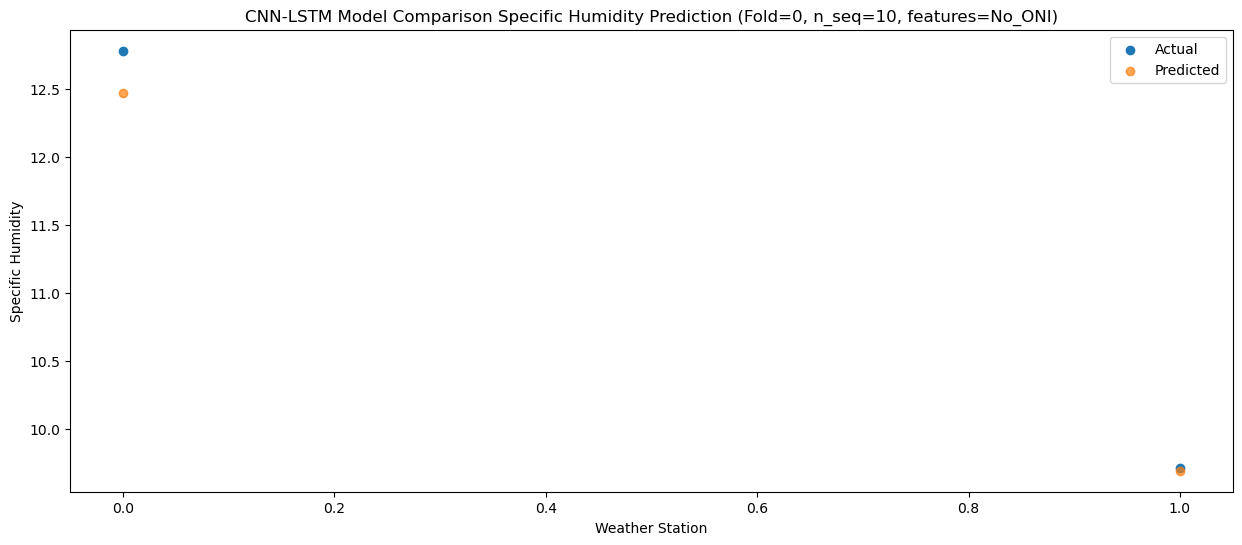

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  13.069084
1                1   10.79  10.284797


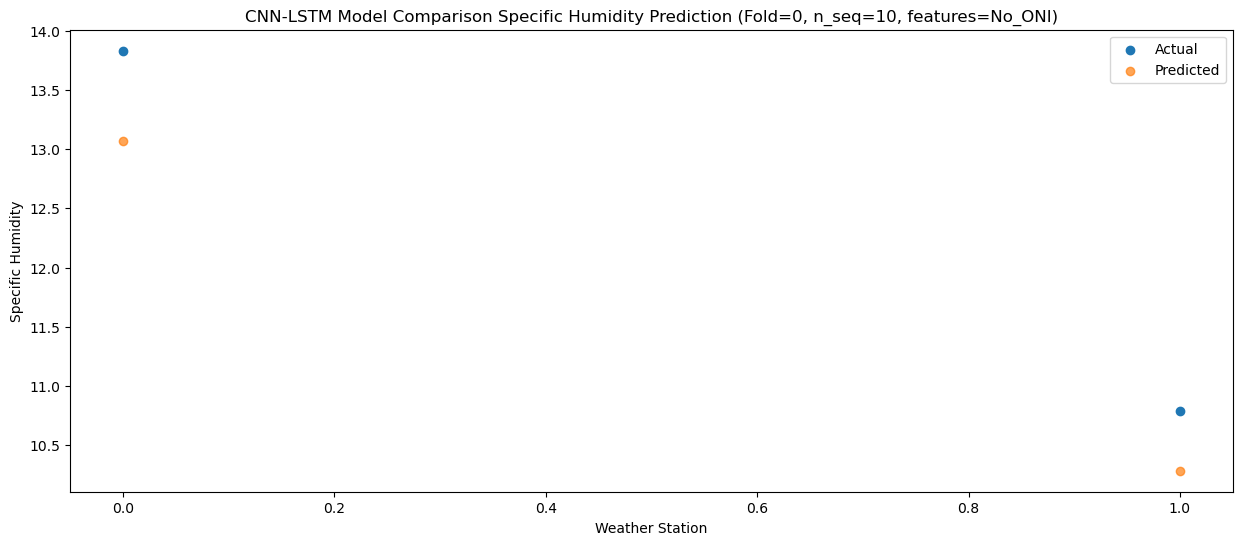

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92  12.873517
1                1   10.20  10.158541


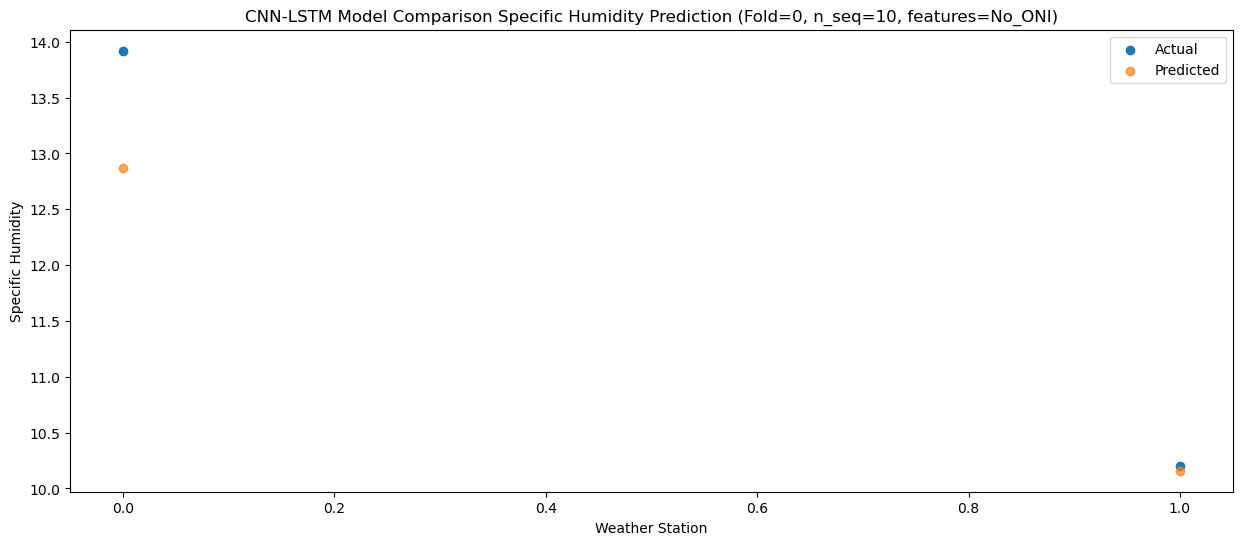

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  13.164560
1                1   10.87  10.336569


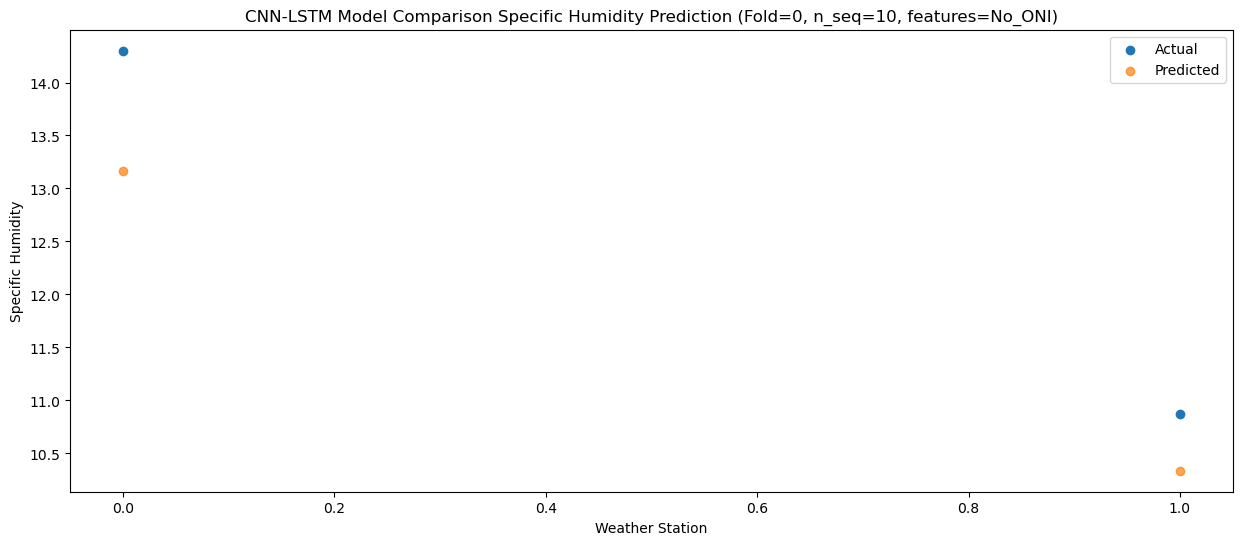

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  13.231947
1                1   10.99  10.478494


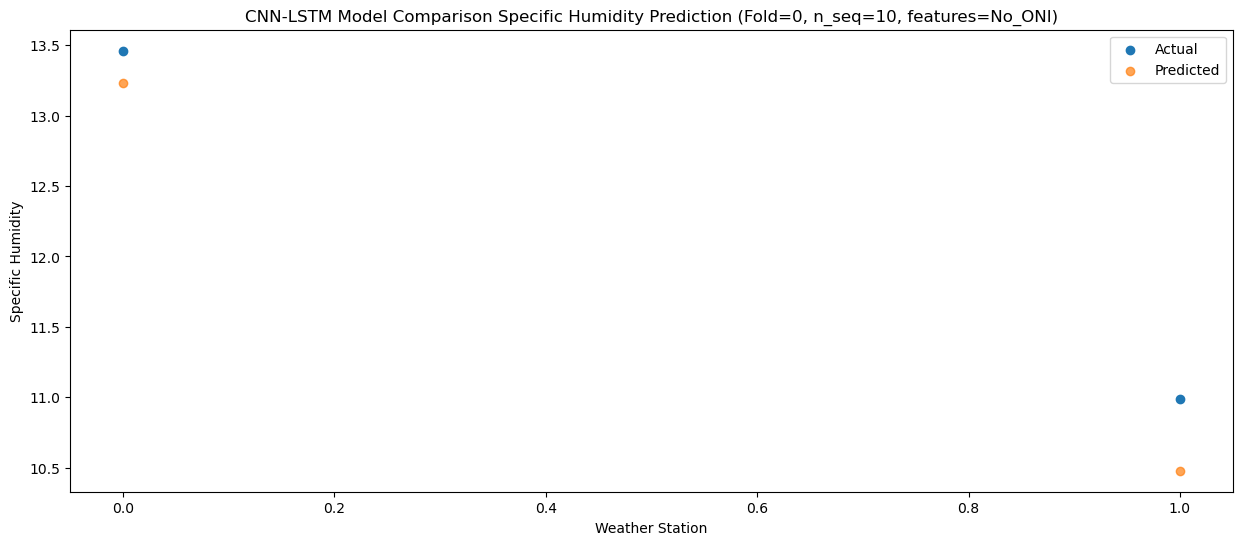

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  12.862563
1                1   10.80  10.077912


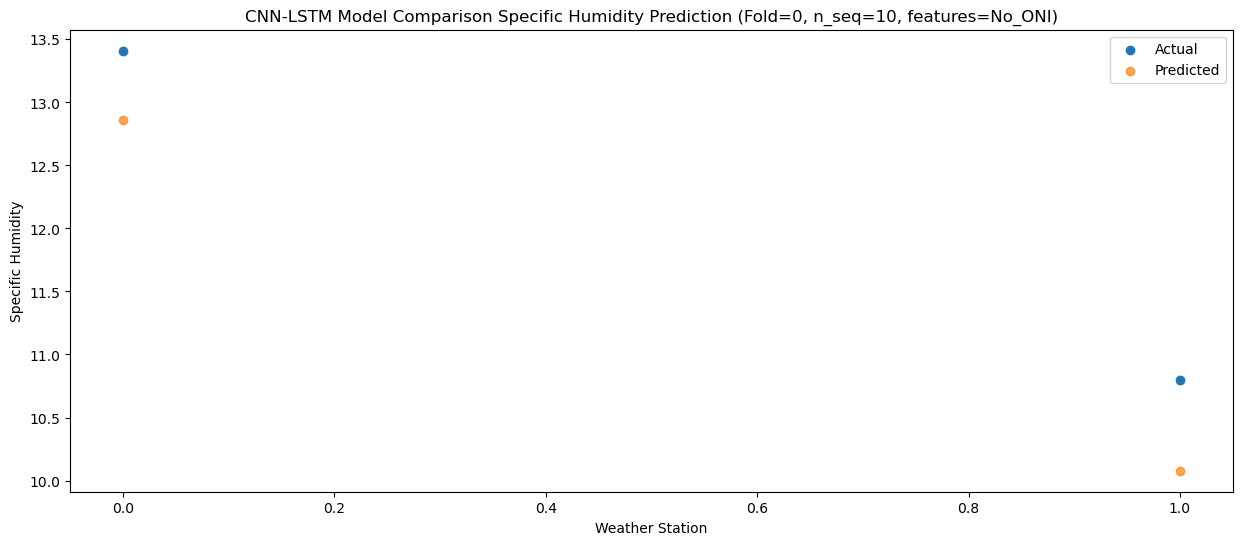

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53  12.886066
1                1   11.01  10.051276


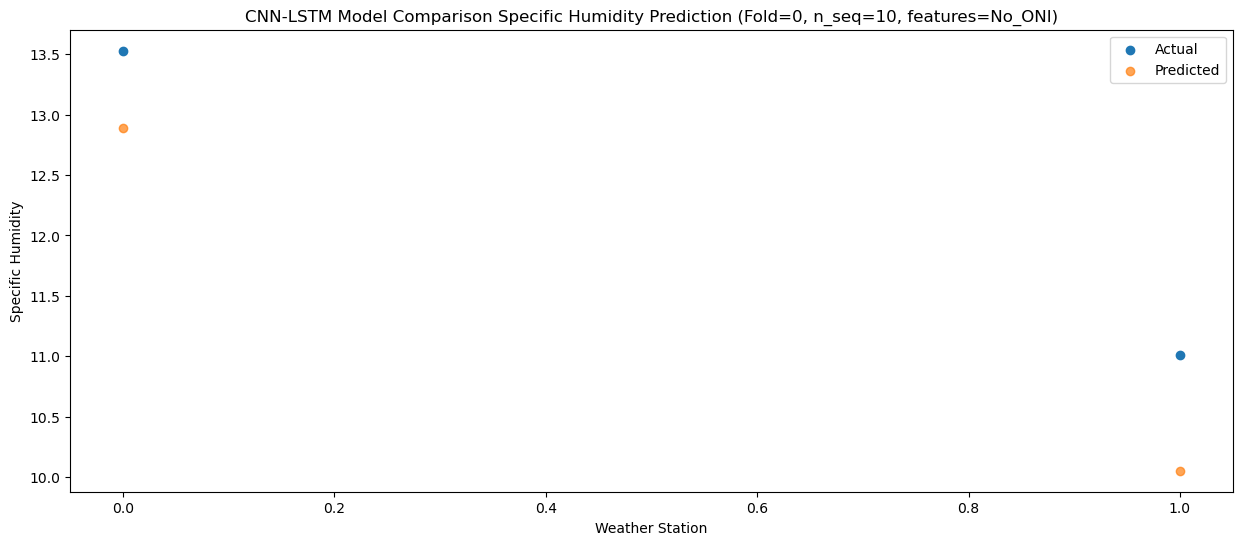

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  12.773156
1                1   10.57  10.025178


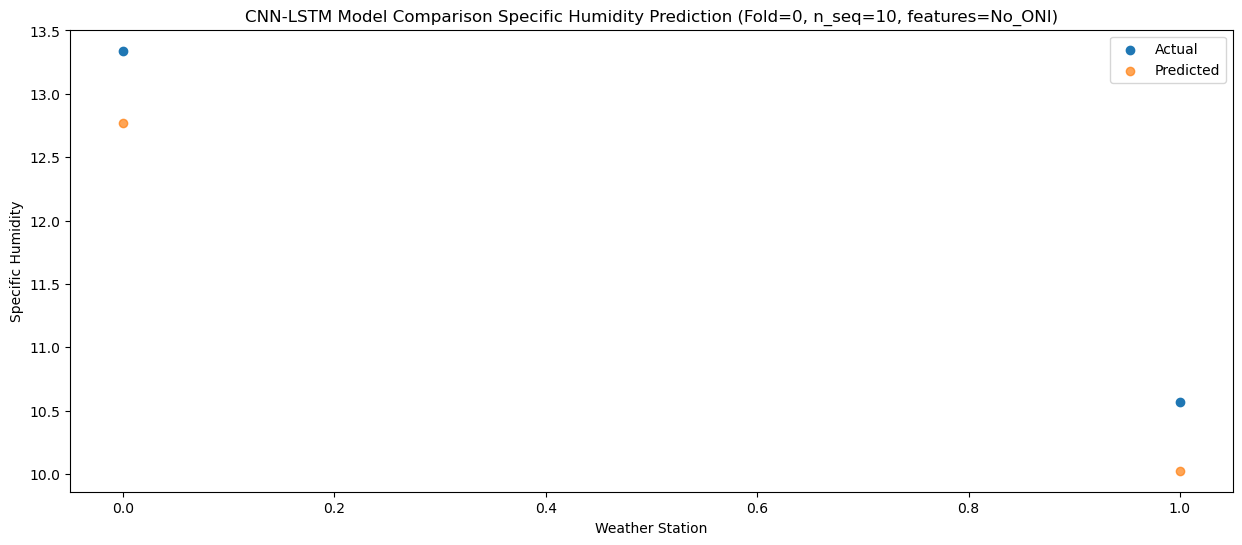

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  12.517225
1                1   10.05   9.749020


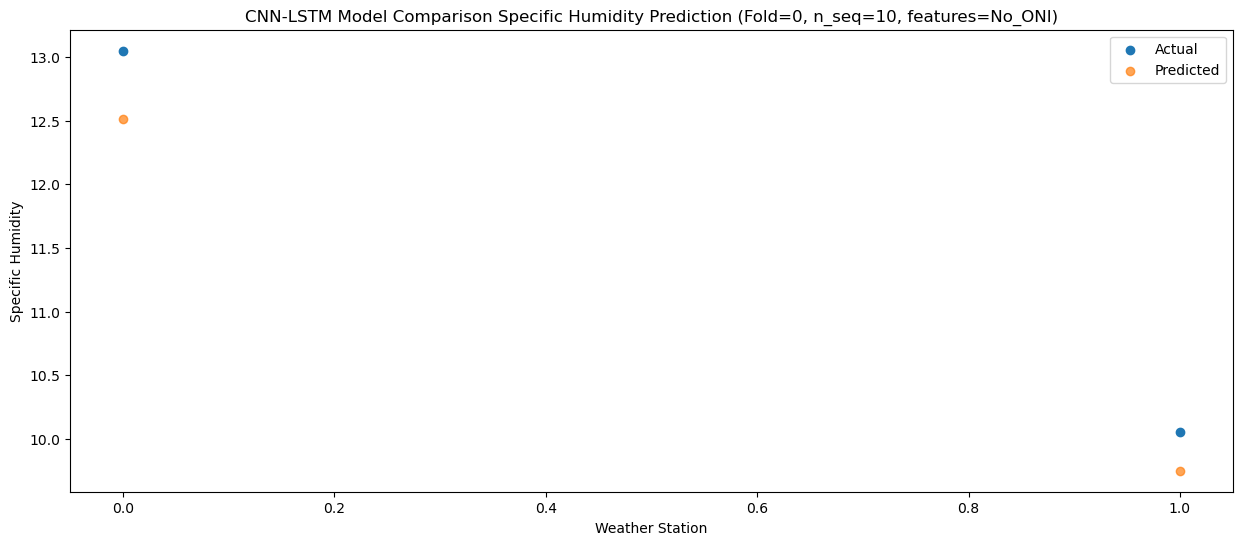

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  12.532089
1                1   10.24   9.761428


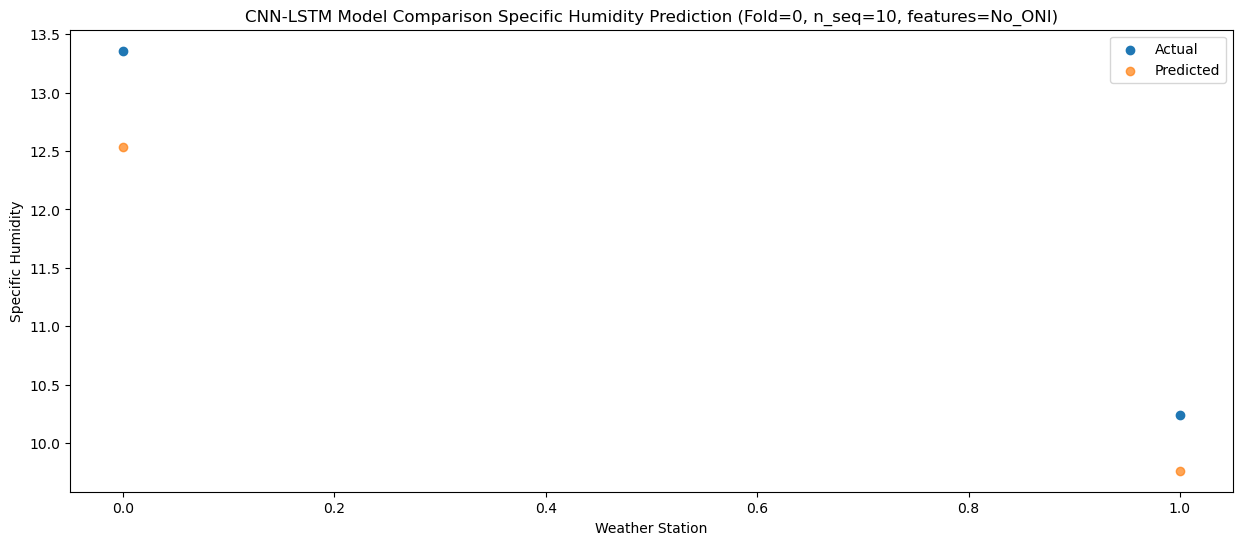

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[12.46924666  9.68994278]
 [13.06908397 10.2847969 ]
 [12.87351715 10.15854078]
 [13.16455977 10.33656944]
 [13.23194697 10.47849429]
 [12.86256292 10.07791213]
 [12.88606552 10.05127628]
 [12.77315557 10.02517823]
 [12.51722491  9.74902034]
 [12.53208912  9.76142802]]
Year at t+1:
t+1 SKRMSE: 0.220193
t+1 KRMSE: 0.220193
t+1 MAE: 0.165405
t+1 SKMAPE: 0.013191
t+1 R2_SCORE: 0.979423
t+1 KMAPE: 0.013191
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.645842
t+2 KRMSE: 0.645842
t+2 MAE: 0.633060
t+2 SKMAPE: 0.050920
t+2 R2_SCORE: 0.819463
t+2 KMAPE: 0.050920
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.740556
t+3 KRMSE: 0.740556
t+3 MAE: 0.543971
t+3 SKMAPE: 0.039621
t+3 R2_SCORE: 0.841478
t+3 KMAPE: 0.039621
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

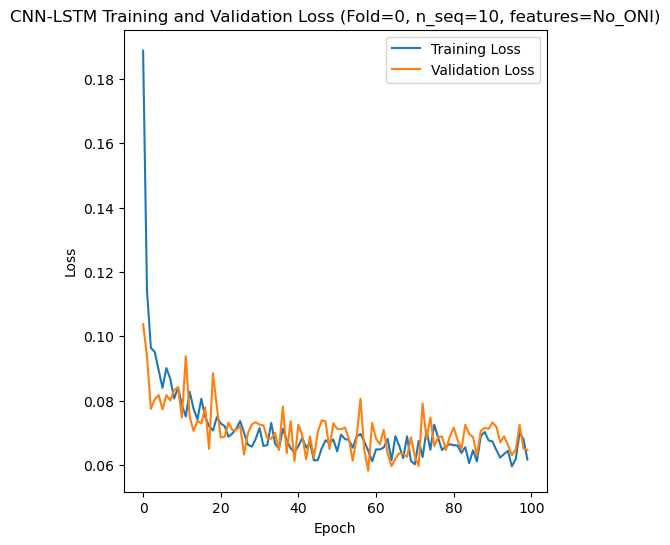

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 37s 656ms/step - loss: 0.1849 - accuracy: 0.3684 - mae: 0.1650 - rmse: 0.1849 - mape: 37.8279 - pearson: 0.1640 - val_loss: 0.0894 - val_accuracy: 0.3333 - val_mae: 0.0674 - val_rmse: 0.0894 - val_mape: 15.8189 - val_pearson: 0.2039
Epoch 2/100
19/19 [==============================] - 3s 165ms/step - loss: 0.1029 - accuracy: 0.3684 - mae: 0.0810 - rmse: 0.1029 - mape: 19.4473 - pearson: 0.2465 - val_loss: 0.1130 - val_accuracy: 0.0000e+00 - val_mae: 0.0919 - val_rmse: 0.1130 - val_mape: 19.2074 - val_pearson: 0.1596
Epoch 3/100
19/19 [==============================] - 3s 164ms/step - loss: 0.1027 - ac

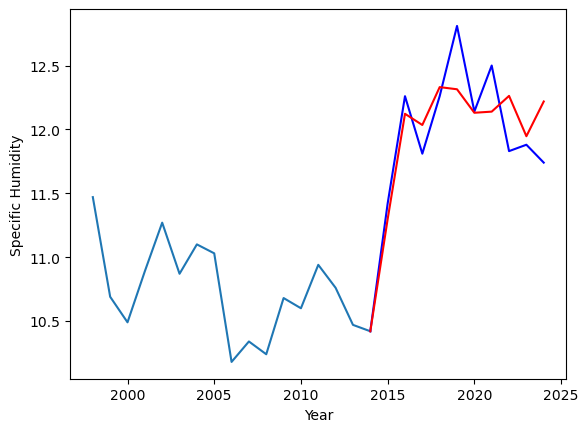

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.91		-0.04
9.08		8.77		-0.31
9.06		8.67		-0.39
8.69		8.99		0.30
8.53		8.46		-0.07
8.56		8.59		0.03
7.82		8.54		0.72
8.26		8.83		0.57
7.69		8.36		0.67
7.84		8.92		1.08


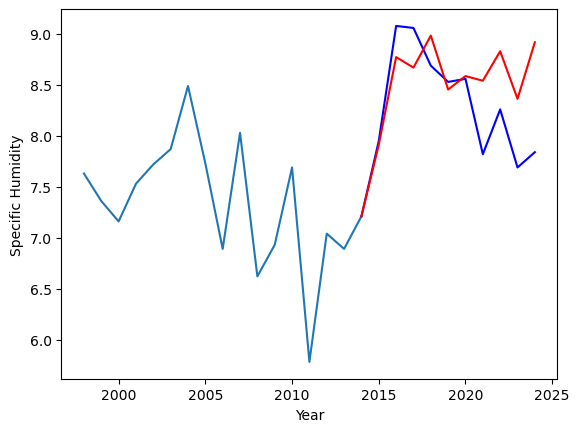

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42  11.297526
1                1    7.95   7.912718


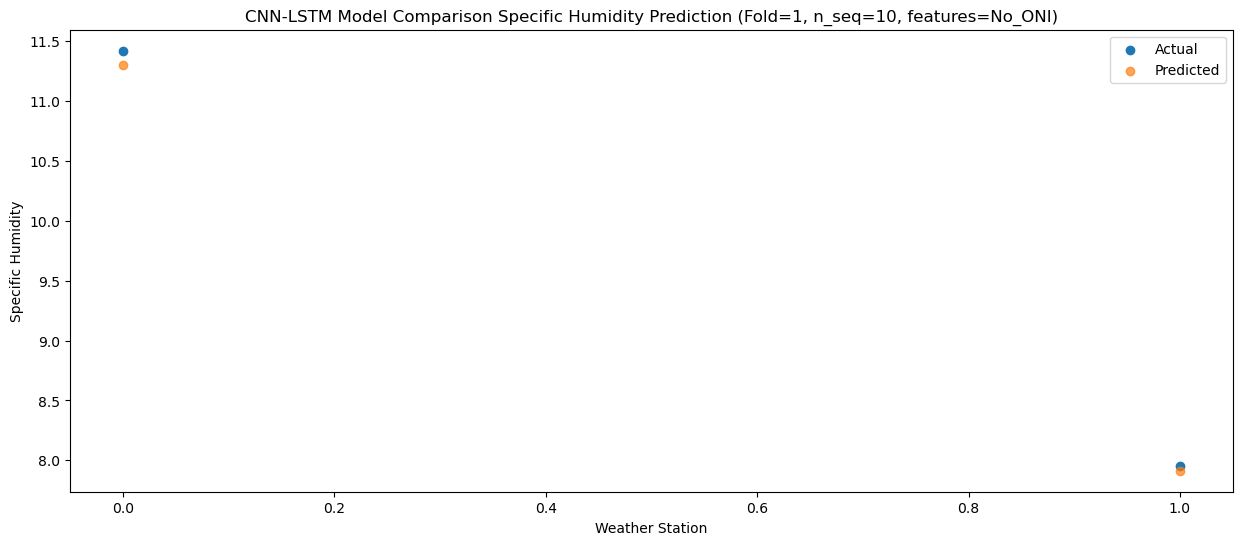

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  12.122133
1                1    9.08   8.773922


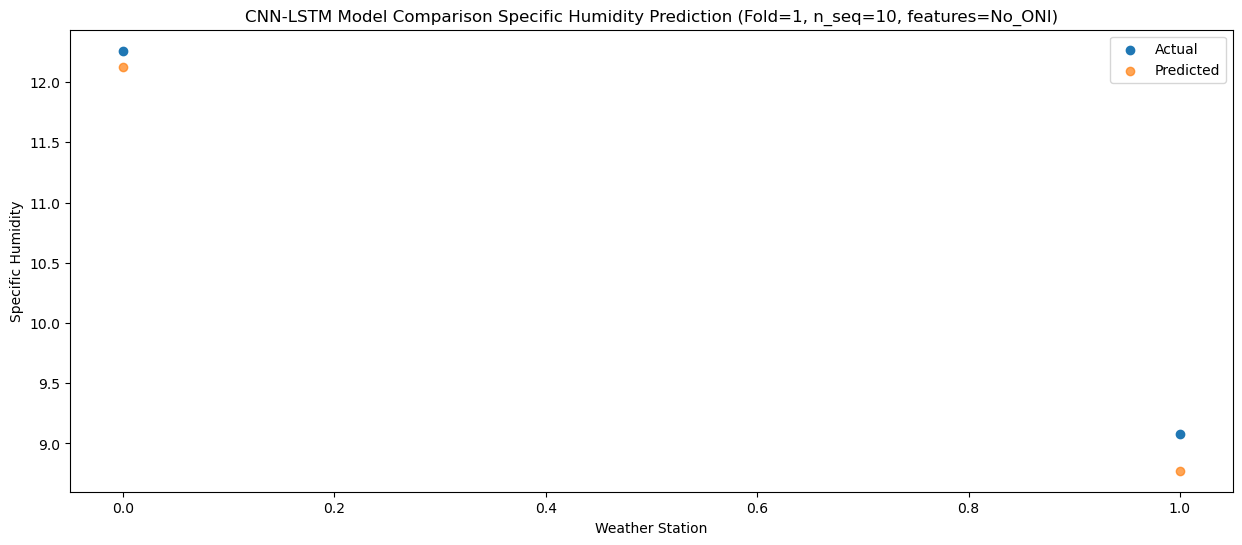

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81  12.034549
1                1    9.06   8.670503


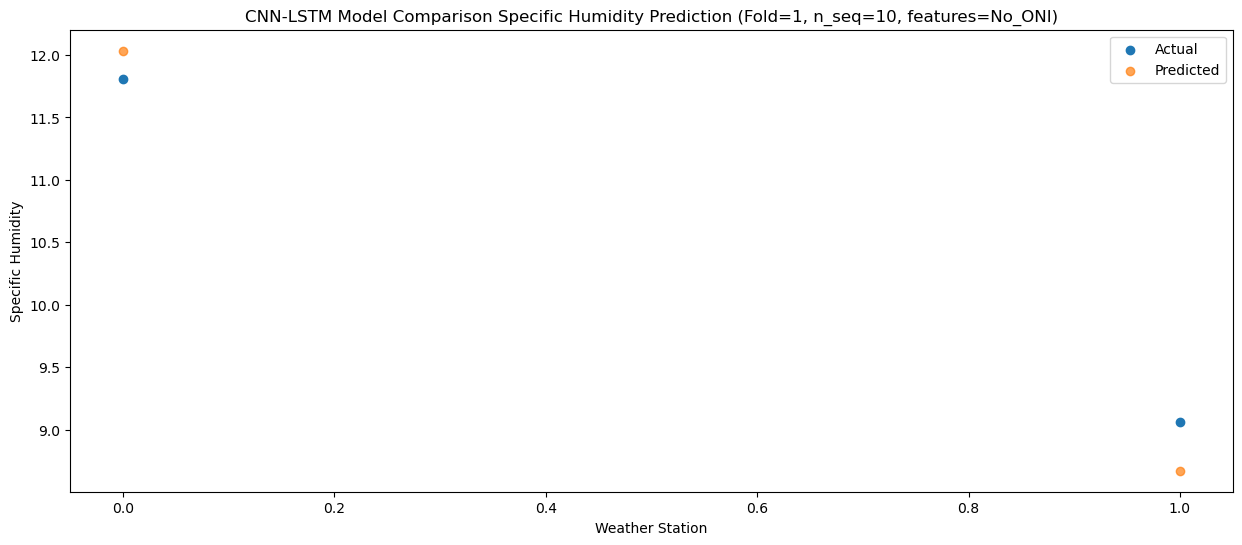

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26  12.331044
1                1    8.69   8.985158


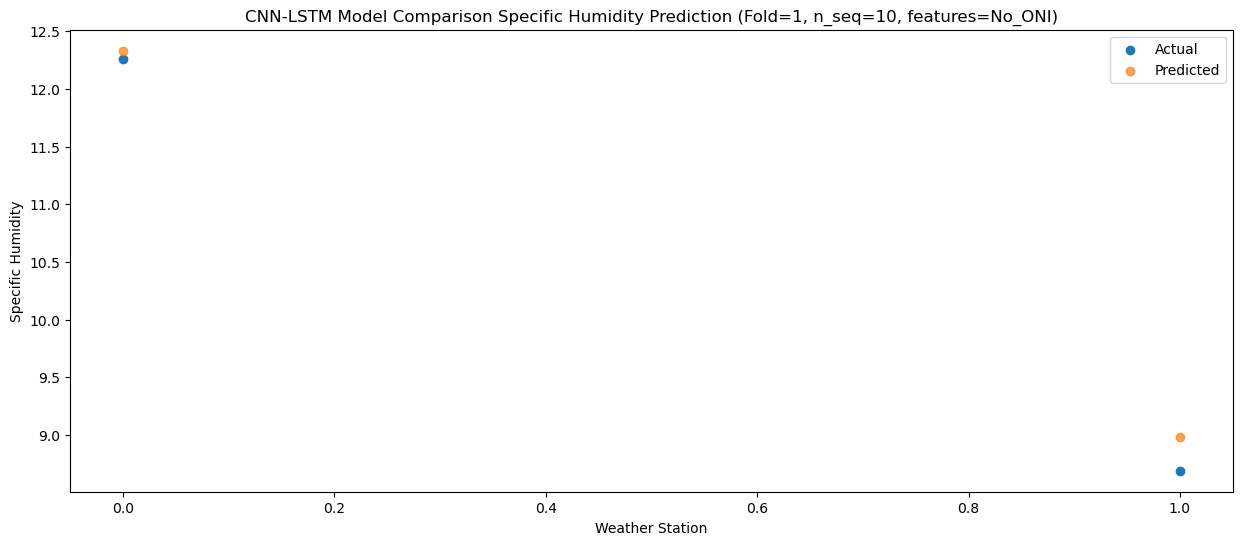

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  12.314145
1                1    8.53   8.455147


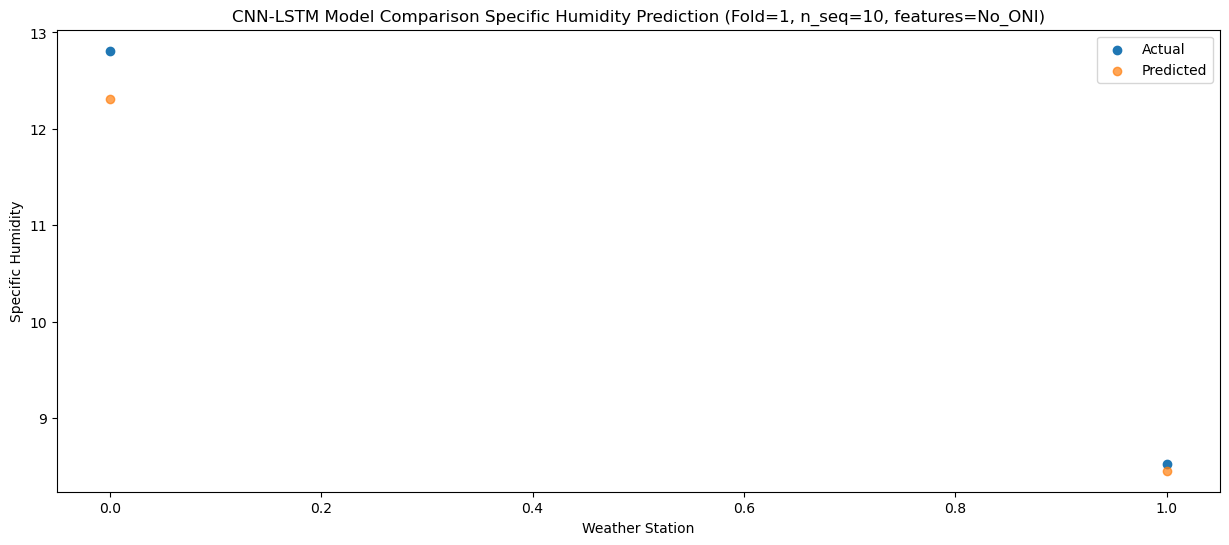

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  12.130232
1                1    8.56   8.587536


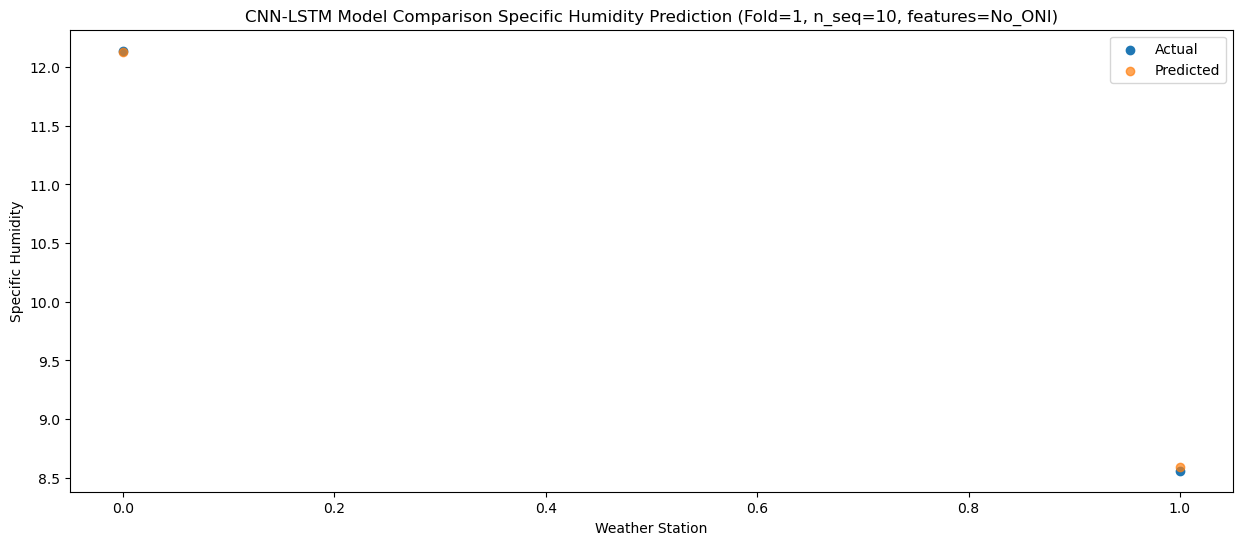

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50  12.139153
1                1    7.82   8.541581


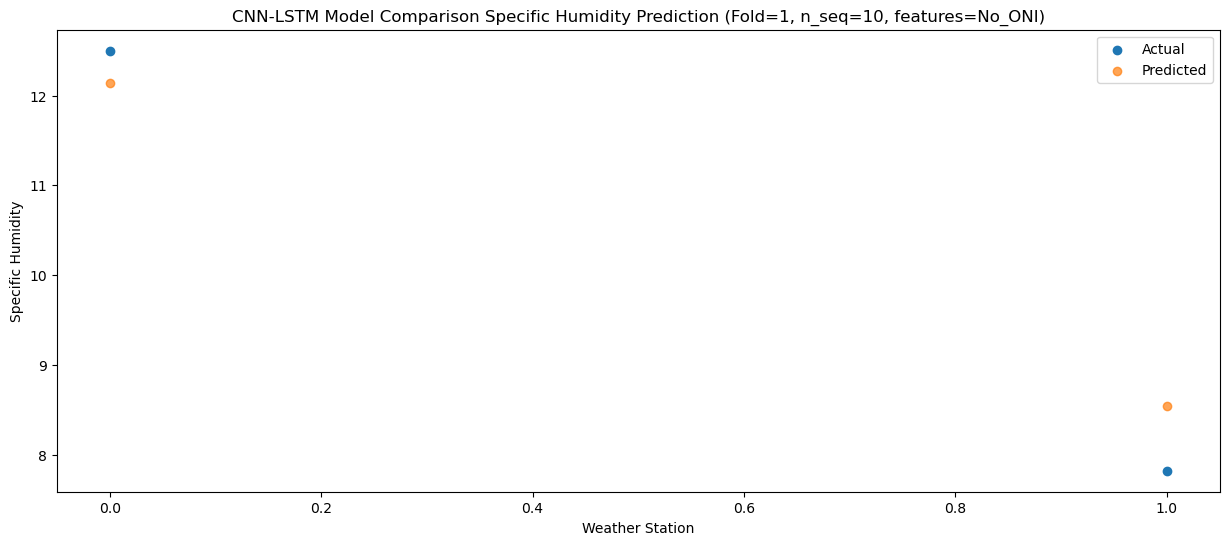

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  12.262422
1                1    8.26   8.831565


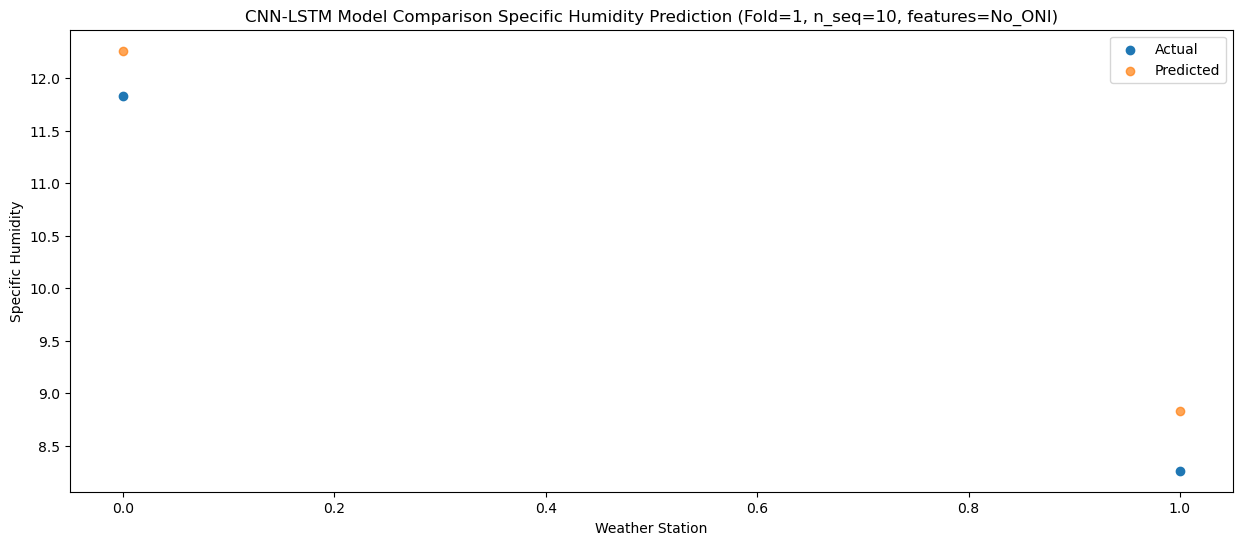

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.946601
1                1    7.69   8.363692


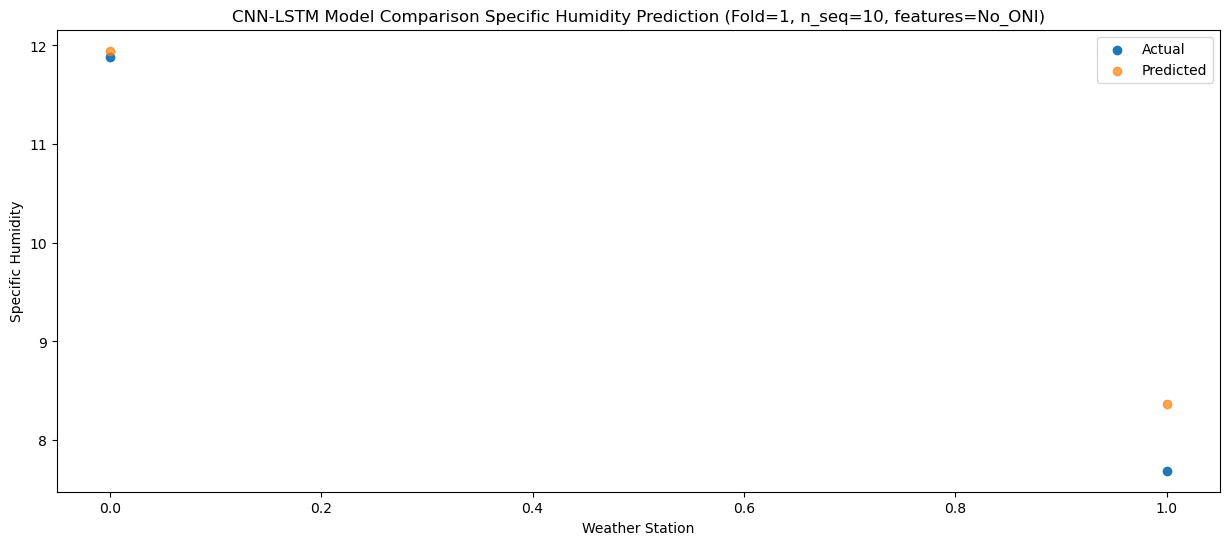

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  12.218459
1                1    7.84   8.919733


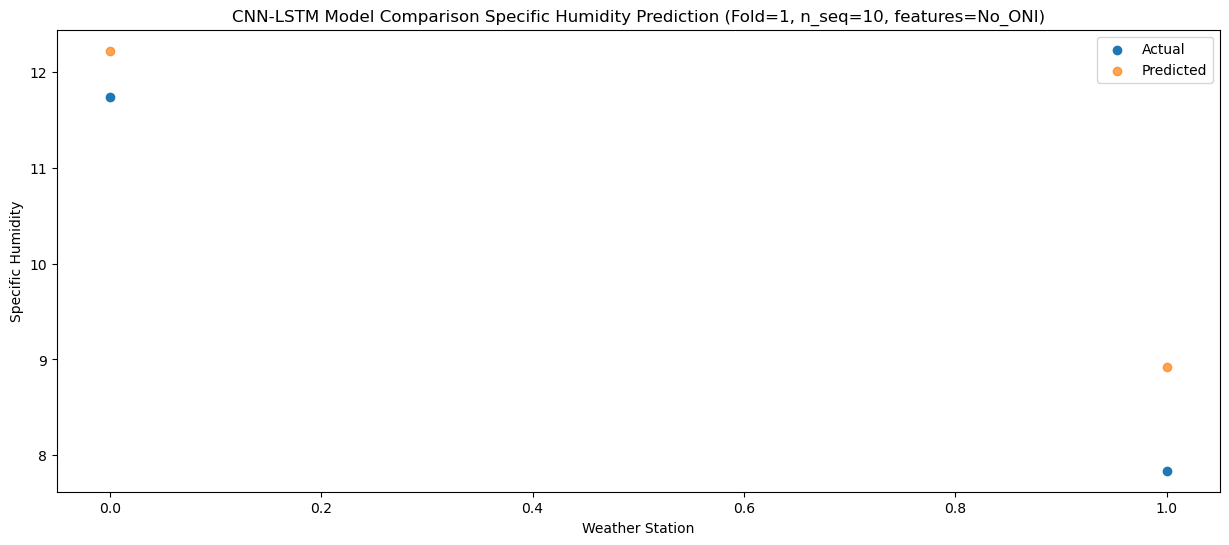

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.29752594  7.91271776]
 [12.12213332  8.77392155]
 [12.0345491   8.6705029 ]
 [12.33104376  8.98515761]
 [12.31414468  8.4551472 ]
 [12.1302319   8.58753639]
 [12.13915312  8.54158092]
 [12.26242234  8.83156452]
 [11.94660105  8.36369175]
 [12.21845923  8.91973269]]
Year at t+1:
t+1 SKRMSE: 0.090526
t+1 KRMSE: 0.090526
t+1 MAE: 0.079878
t+1 SKMAPE: 0.007707
t+1 R2_SCORE: 0.997278
t+1 KMAPE: 0.007707
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 0.237372
t+2 KRMSE: 0.237372
t+2 MAE: 0.221973
t+2 SKMAPE: 0.022477
t+2 R2_SCORE: 0.977712
t+2 KMAPE: 0.022477
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 0.317907
t+3 KRMSE: 0.317907
t+3 MAE: 0.307023
t+3 SKMAPE: 0.031002
t+3 R2_SCORE: 0.946544
t+3 KMAPE: 0.031002
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at t

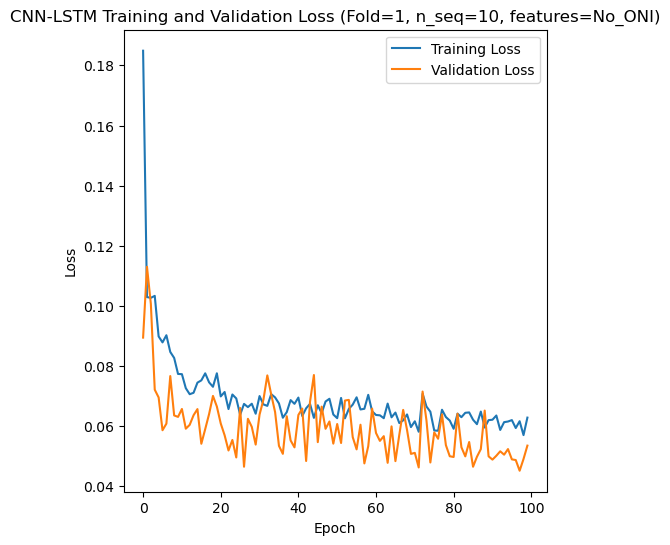

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 27s 464ms/step - loss: 0.1933 - accuracy: 0.0526 - mae: 0.1710 - rmse: 0.1933 - mape: 39.2681 - pearson: 0.0897 - val_loss: 0.1149 - val_accuracy: 0.0000e+00 - val_mae: 0.0922 - val_rmse: 0.1149 - val_mape: 21.2323 - val_pearson: 0.0519
Epoch 2/100
19/19 [==============================] - 2s 82ms/step - loss: 0.1045 - accuracy: 0.4737 - mae: 0.0877 - rmse: 0.1045 - mape: 19.9521 - pearson: 0.3253 - val_loss: 0.0946 - val_accuracy: 0.0000e+00 - val_mae: 0.0691 - val_rmse: 0.0946 - val_mape: 15.7216 - val_pearson: 0.1265
Epoch 3/100
19/19 [==============================] - 2s 95ms/step - loss: 0.1015 - 

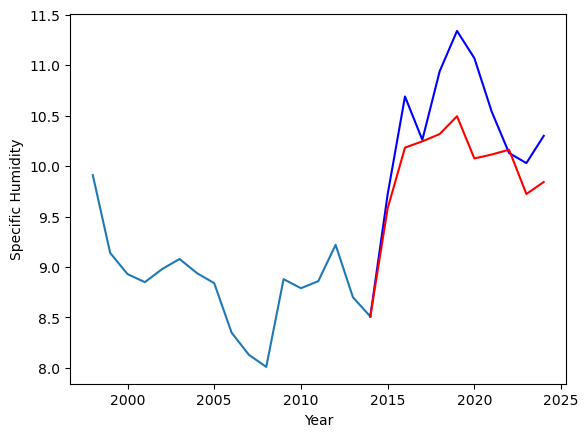

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.19		0.51
8.43		8.68		0.25
8.98		8.81		-0.17
8.93		8.79		-0.14
9.03		9.23		0.20
8.38		8.79		0.41
8.20		8.84		0.64
8.27		9.00		0.73
8.54		8.60		0.06
8.55		8.74		0.19


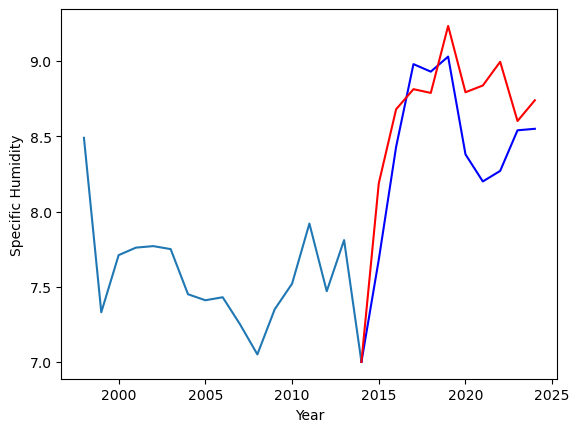

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72   9.581428
1                1    7.68   8.187447


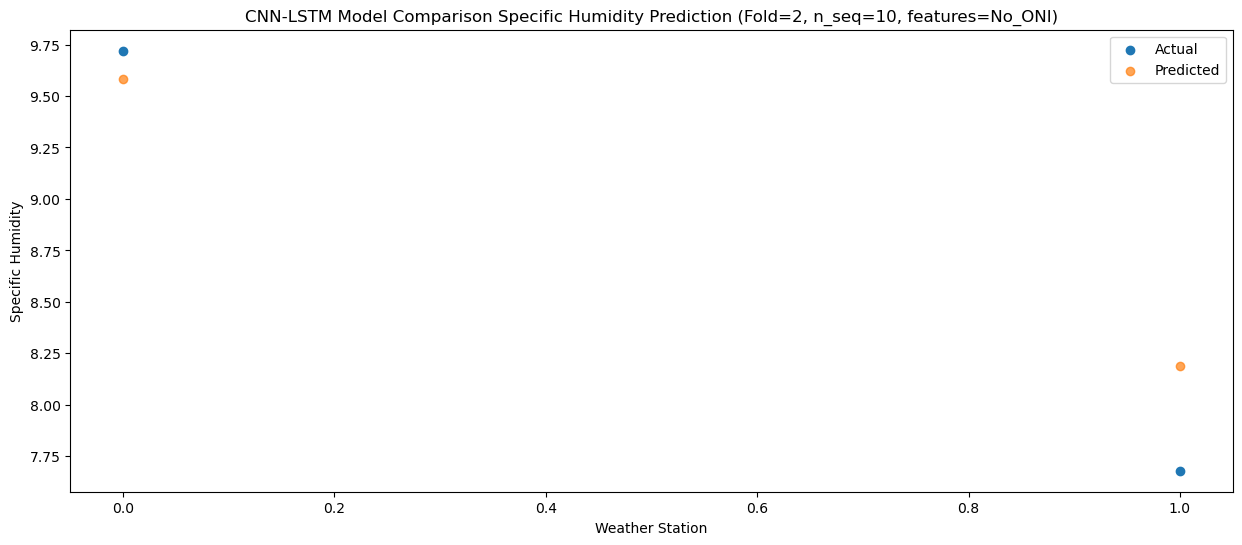

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.183100
1                1    8.43   8.679878


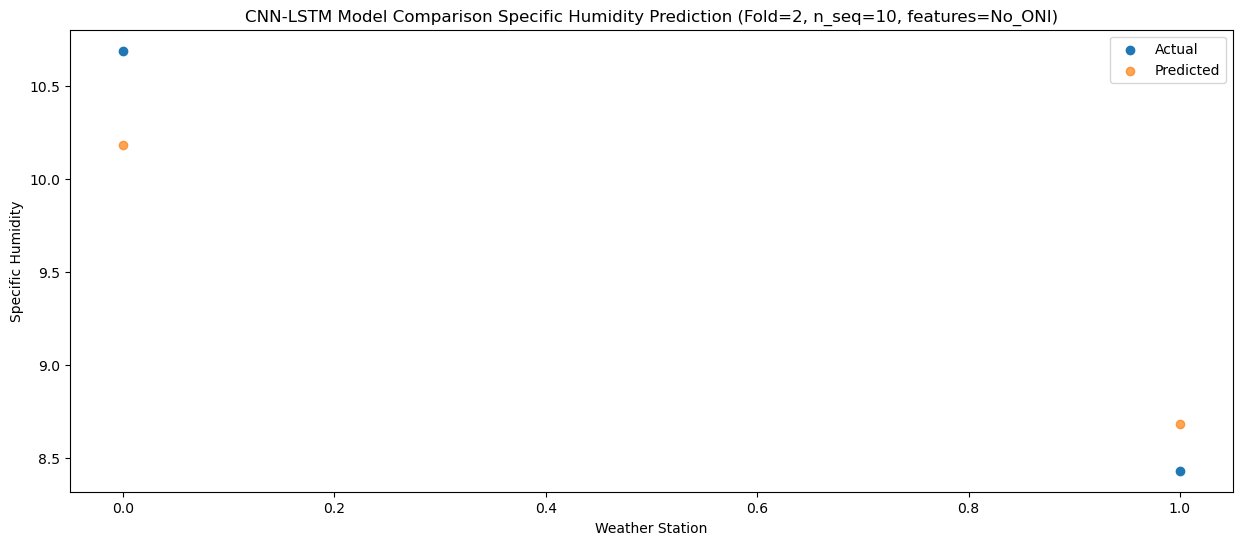

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26  10.245671
1                1    8.98   8.813421


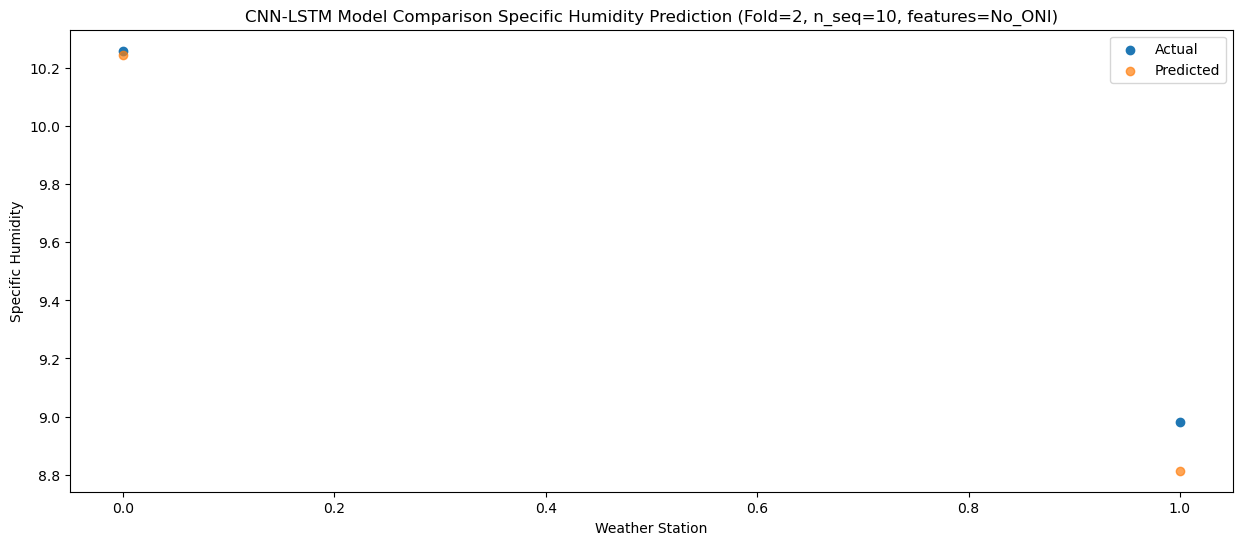

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94  10.317967
1                1    8.93   8.788588


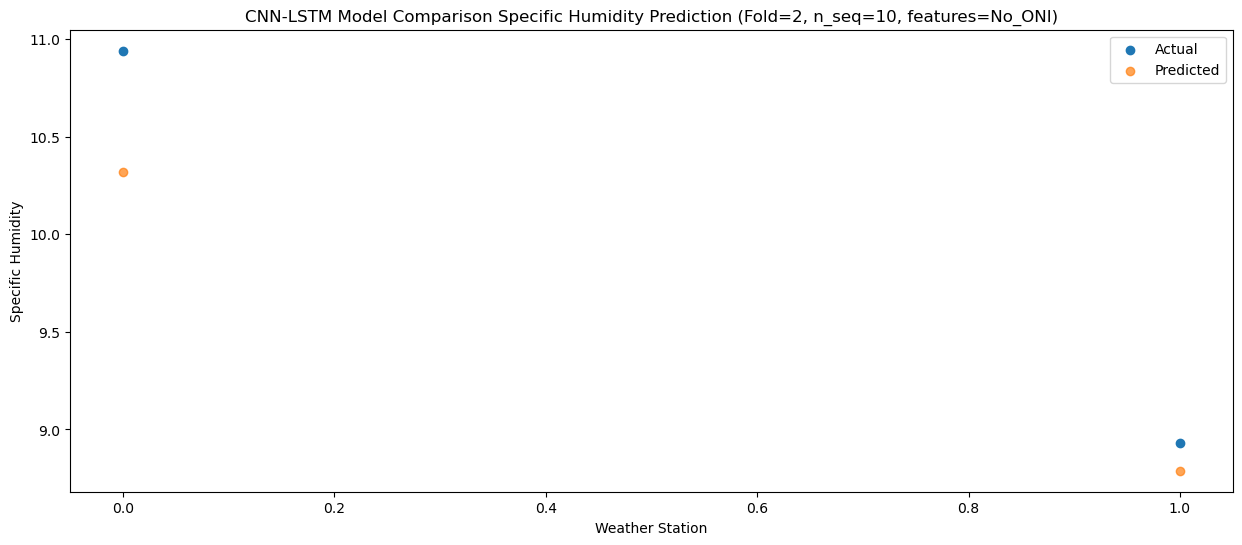

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34  10.494676
1                1    9.03   9.234014


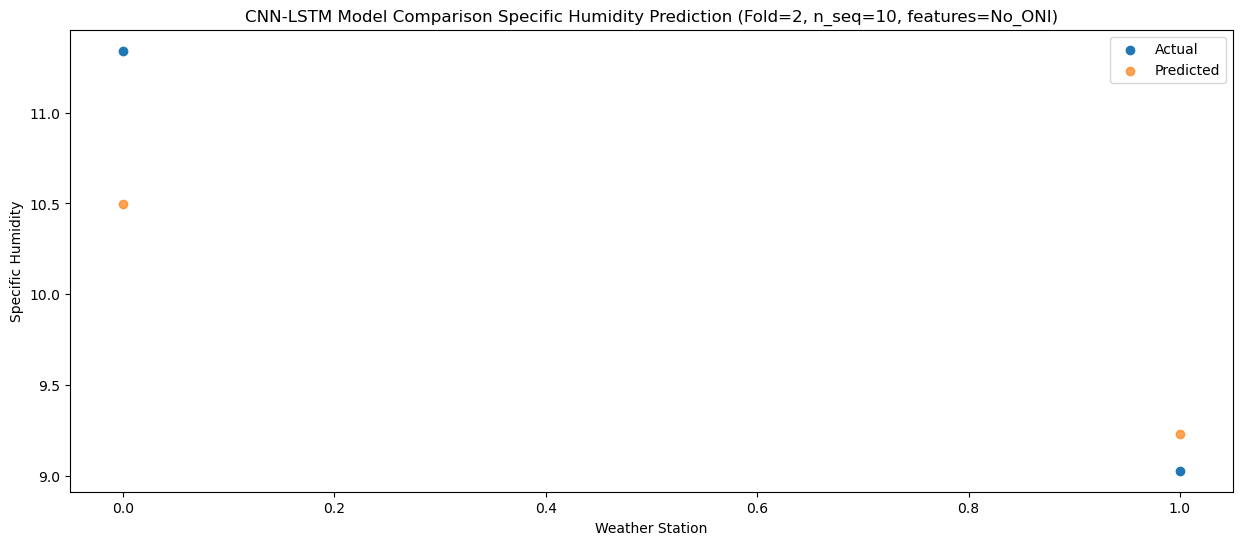

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.075972
1                1    8.38   8.792919


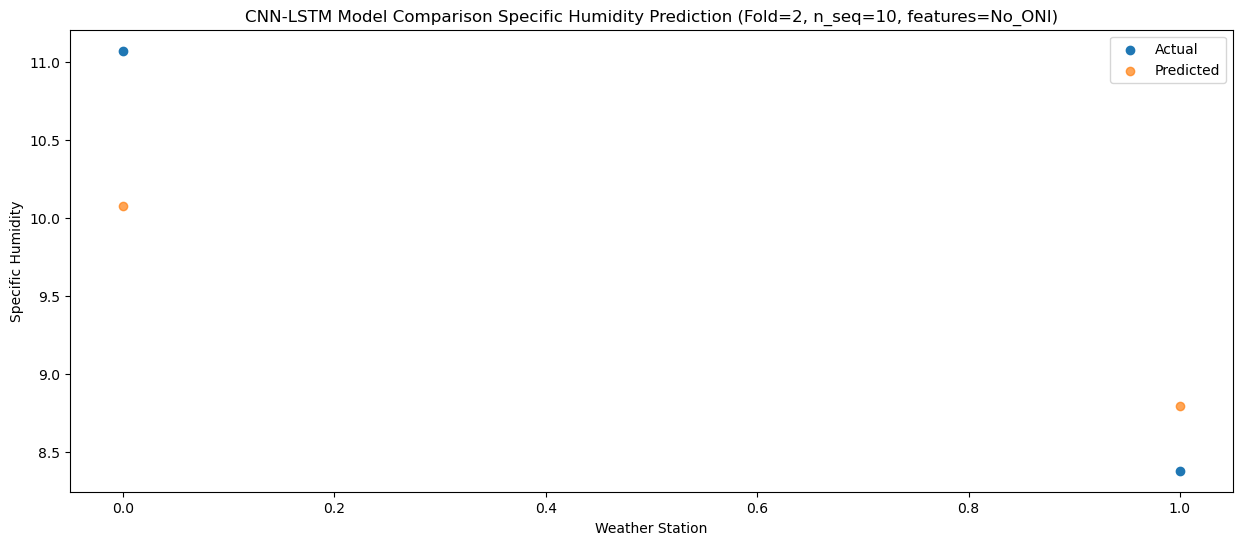

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54  10.115105
1                1    8.20   8.837851


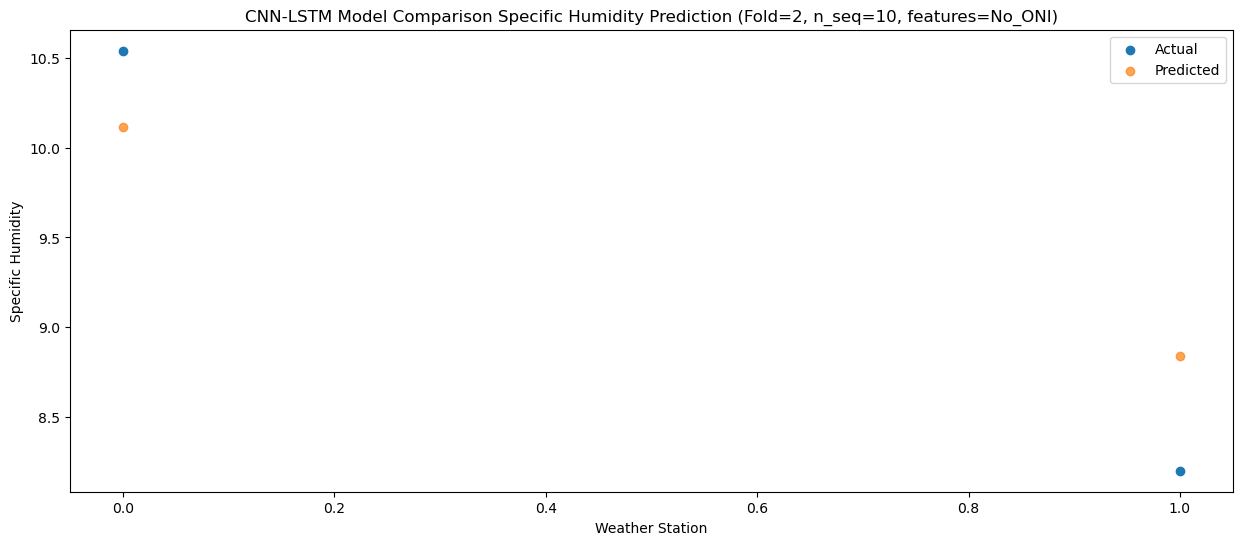

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13  10.162836
1                1    8.27   8.995503


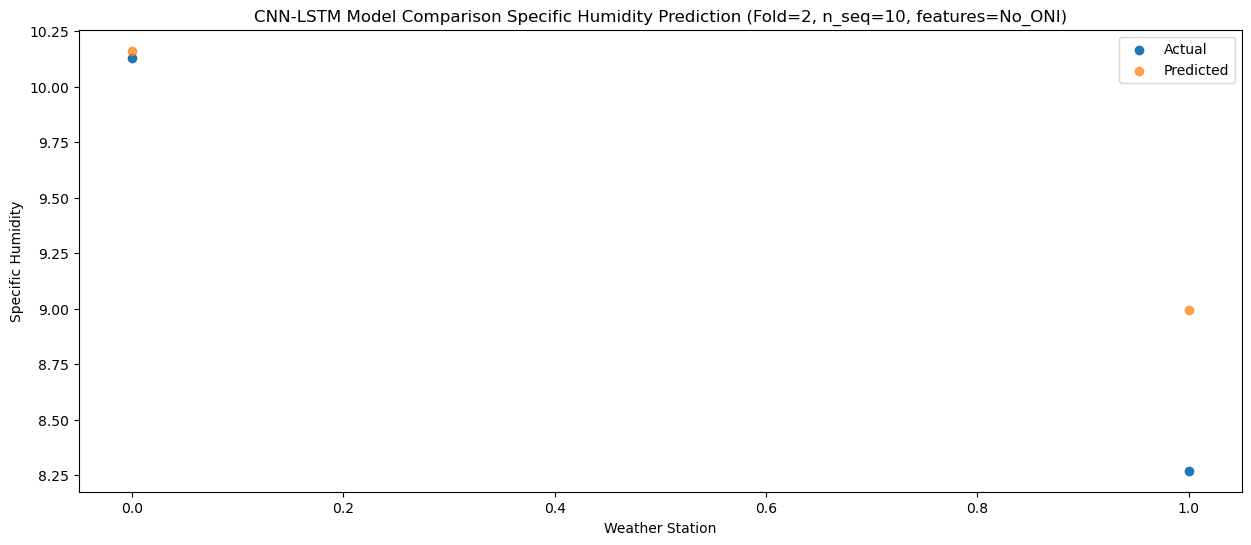

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03   9.723855
1                1    8.54   8.601737


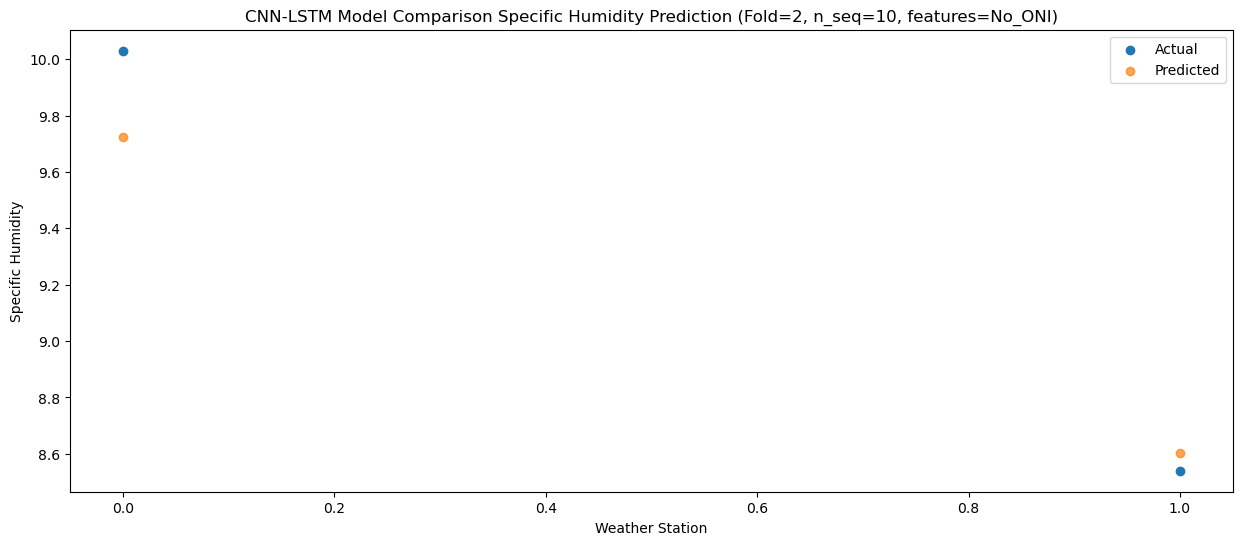

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30   9.842484
1                1    8.55   8.739716


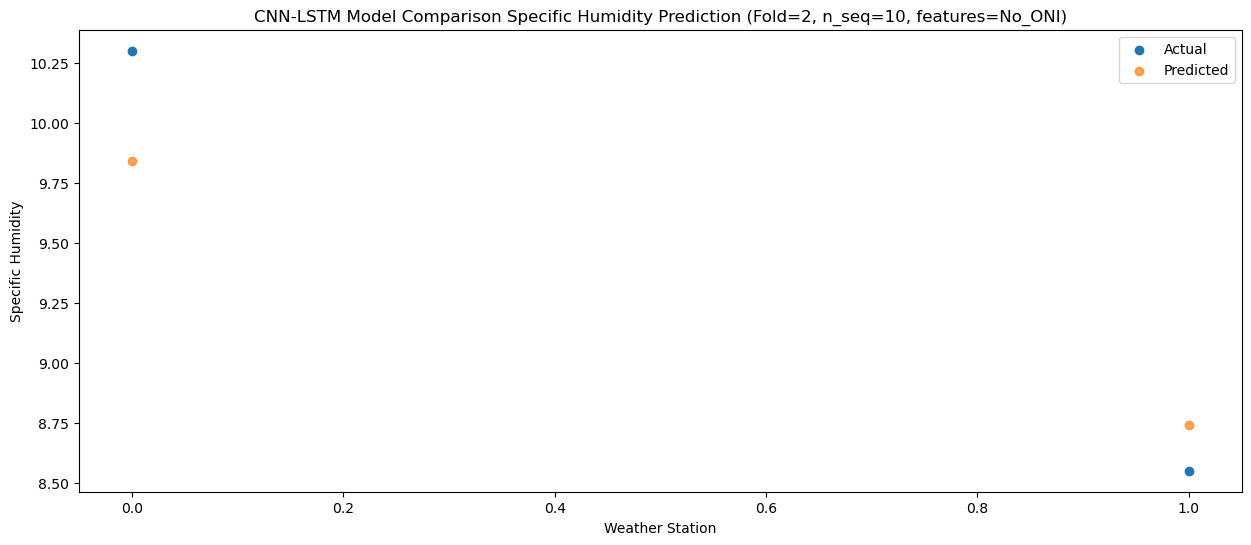

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[ 9.58142814  8.18744706]
 [10.18310038  8.67987808]
 [10.24567113  8.8134207 ]
 [10.31796676  8.78858848]
 [10.49467648  9.23401422]
 [10.07597221  8.79291905]
 [10.11510519  8.83785053]
 [10.16283559  8.99550313]
 [ 9.72385453  8.60173658]
 [ 9.84248402  8.73971648]]
Year at t+1:
t+1 SKRMSE: 0.371957
t+1 KRMSE: 0.371957
t+1 MAE: 0.323009
t+1 SKMAPE: 0.040165
t+1 R2_SCORE: 0.867020
t+1 KMAPE: 0.040165
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.399616
t+2 KRMSE: 0.399616
t+2 MAE: 0.378389
t+2 SKMAPE: 0.038530
t+2 R2_SCORE: 0.874937
t+2 KMAPE: 0.038530
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.118224
t+3 KRMSE: 0.118224
t+3 MAE: 0.090454
t+3 SKMAPE: 0.009973
t+3 R2_SCORE: 0.965876
t+3 KMAPE: 0.009973
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

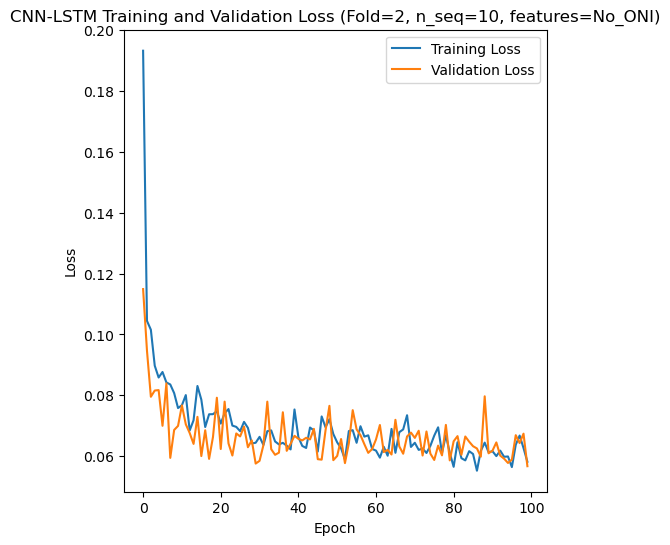

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 35s 550ms/step - loss: 0.2635 - accuracy: 0.4000 - mae: 0.2361 - rmse: 0.2635 - mape: 39.5804 - pearson: 0.1868 - val_loss: 0.0876 - val_accuracy: 0.5000 - val_mae: 0.0676 - val_rmse: 0.0876 - val_mape: 11.0180 - val_pearson: 0.4047
Epoch 2/100
20/20 [==============================] - 3s 141ms/step - loss: 0.1654 - accuracy: 0.4000 - mae: 0.1361 - rmse: 0.1654 - mape: 22.7159 - pearson: 0.2092 - val_loss: 0.1144 - val_accuracy: 0.5000 - val_mae: 0.0969 - val_rmse: 0.1144 - val_mape: 15.7452 - val_pearson: 0.5066
Epoch 3/100
20/20 [==============================] - 3s 142ms/step - loss: 0.1505 - accuracy: 0.5000 - mae: 0.1246 - rmse: 0.1505 - mape: 21.1240 - 

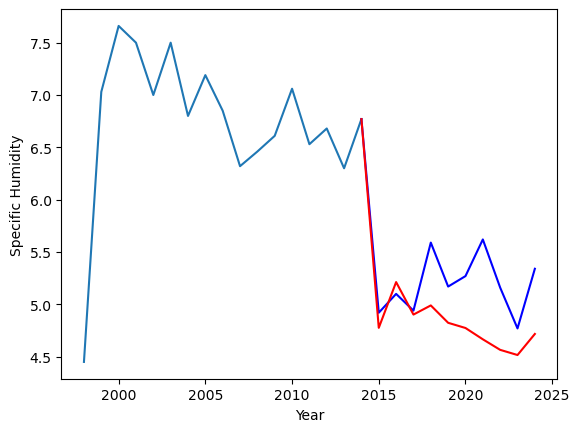

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		8.03		0.08
8.59		8.59		0.00
8.69		8.45		-0.24
8.51		8.61		0.10
8.87		8.81		-0.06
8.75		8.41		-0.34
8.66		8.36		-0.30
8.63		8.24		-0.39
8.16		7.97		-0.19
8.18		8.16		-0.02


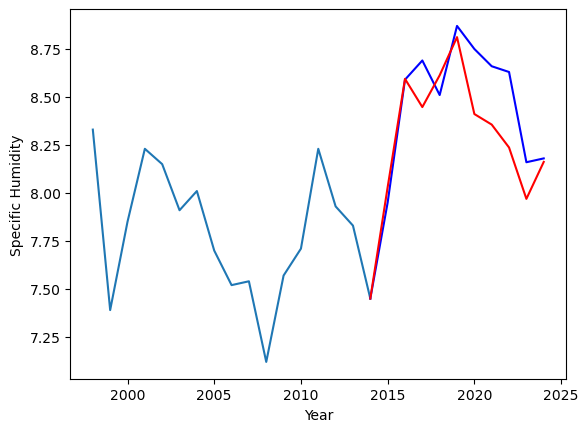

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   4.775626
1                1    7.95   8.029994


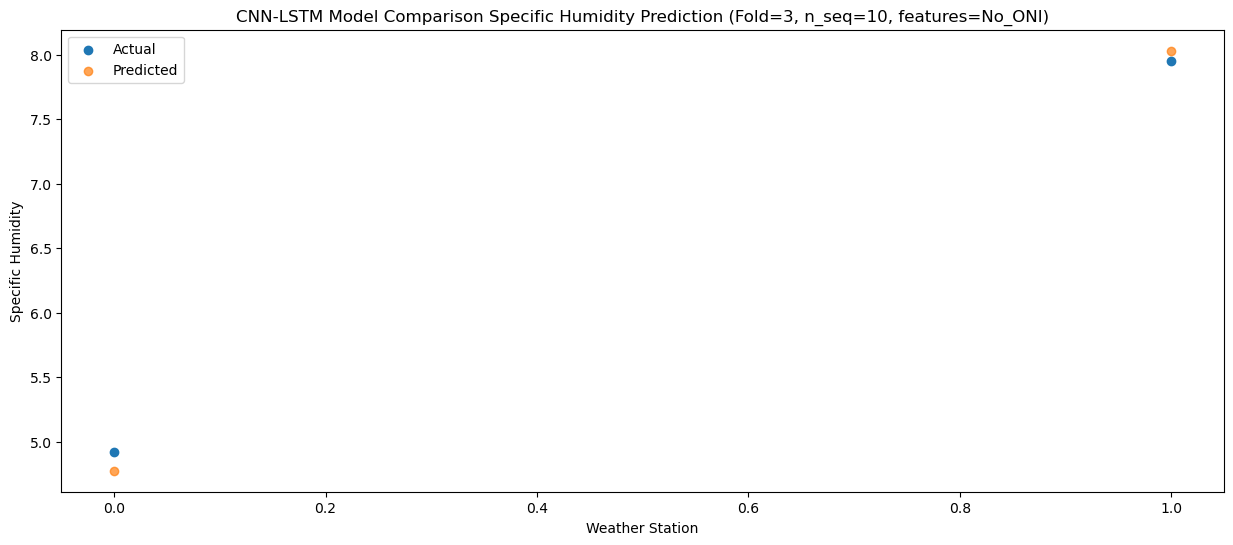

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10   5.212756
1                1    8.59   8.594289


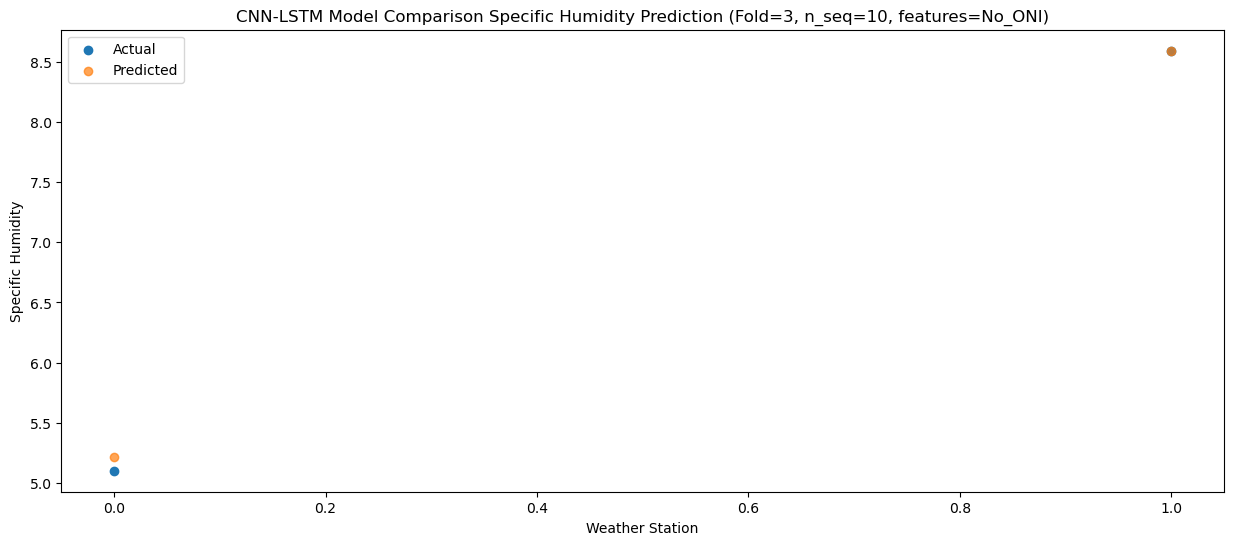

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.902365
1                1    8.69   8.447323


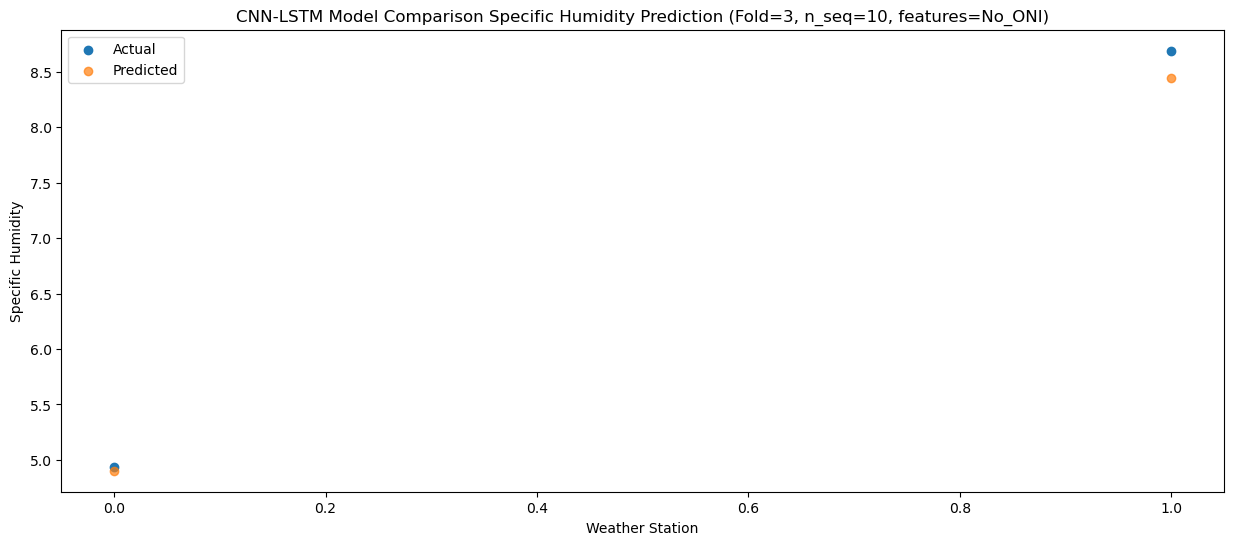

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   4.989767
1                1    8.51   8.612987


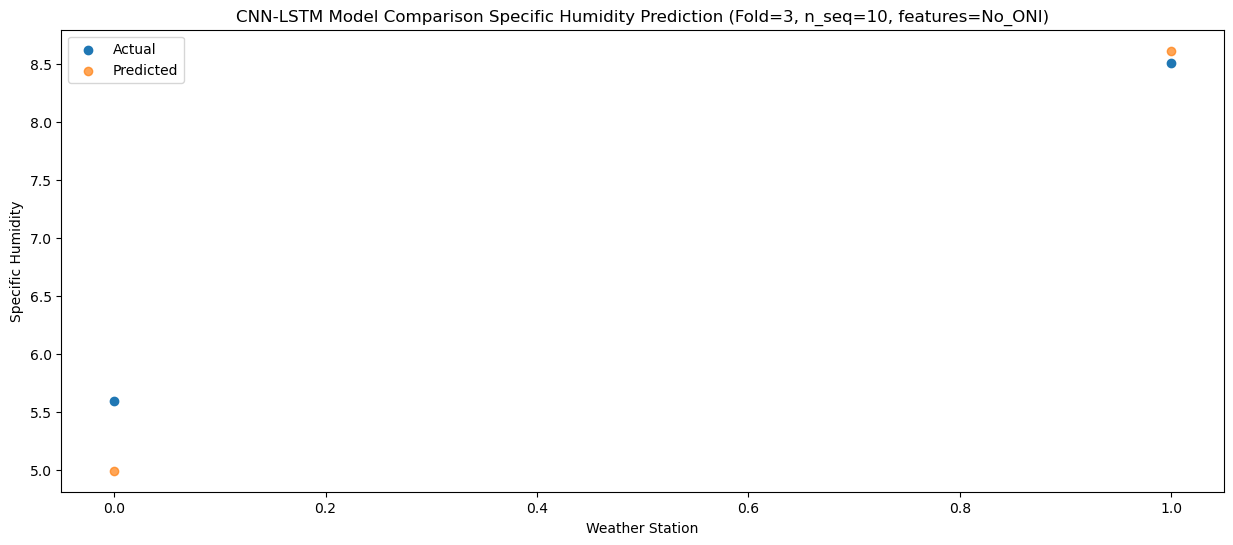

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17   4.823756
1                1    8.87   8.811645


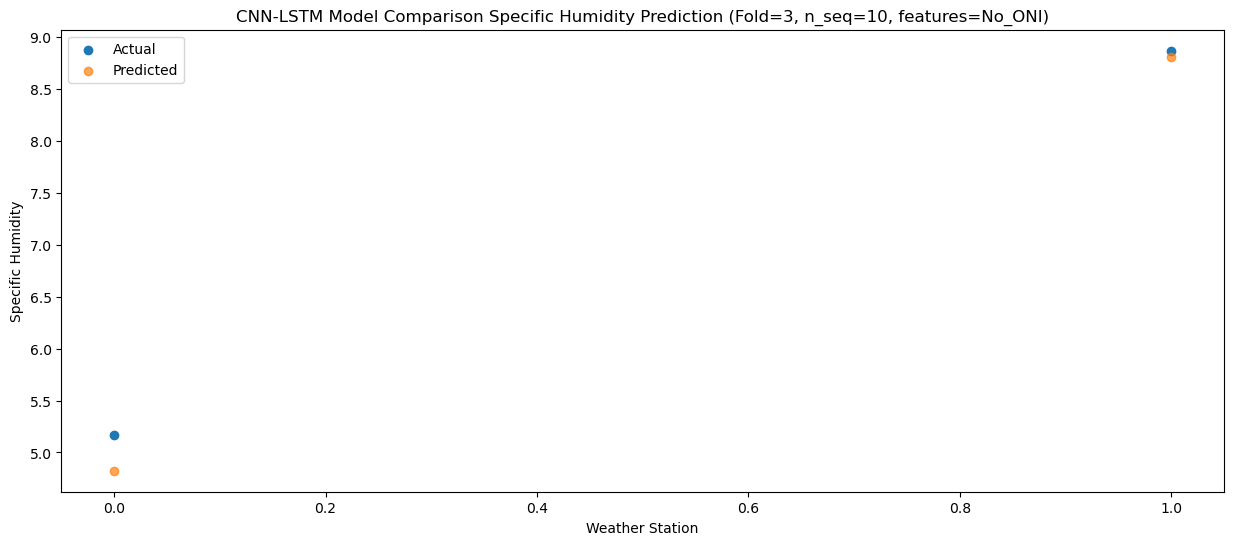

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.774109
1                1    8.75   8.411123


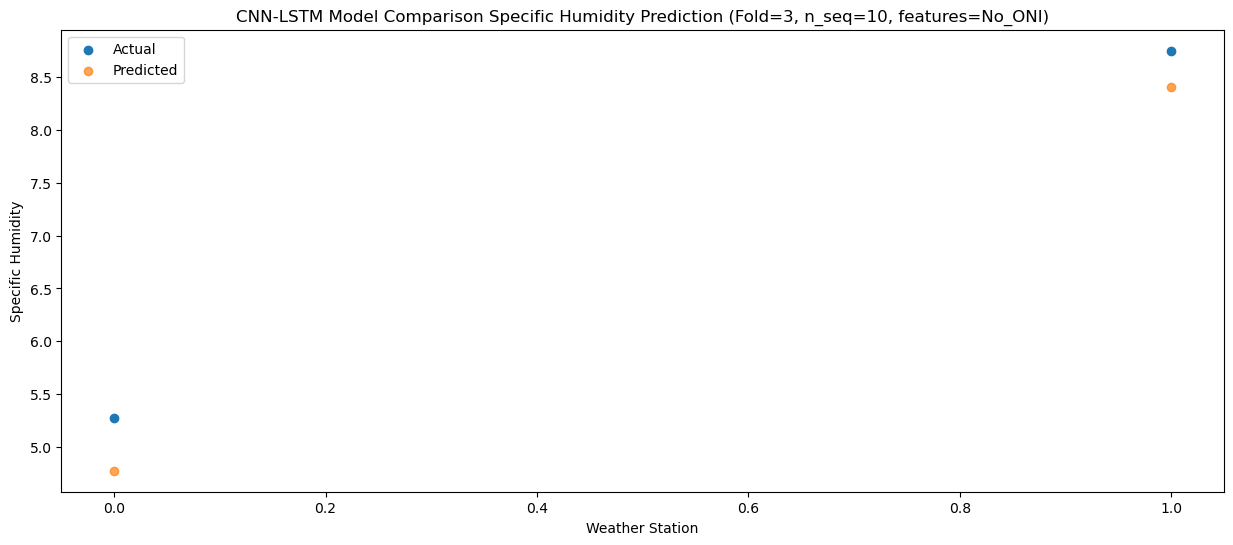

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.666063
1                1    8.66   8.356136


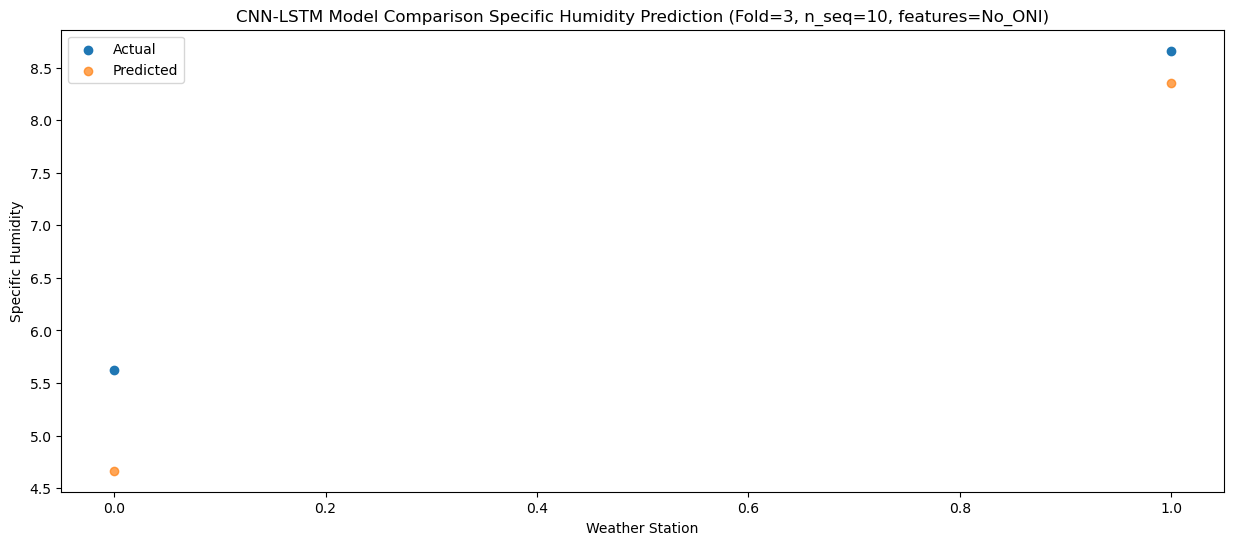

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.565313
1                1    8.63   8.236755


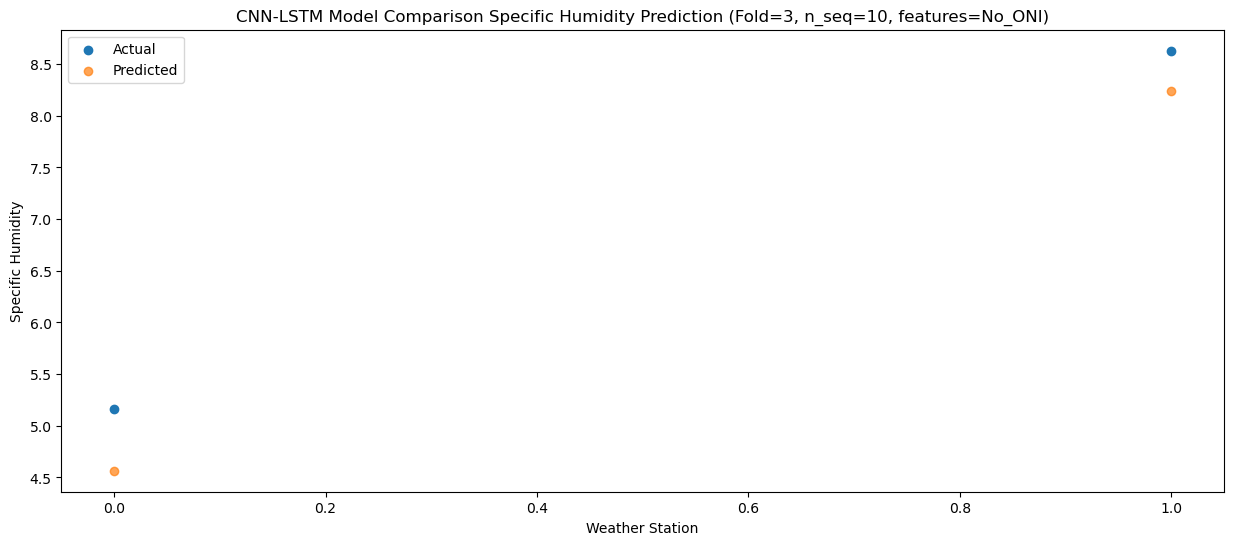

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.515897
1                1    8.16   7.969212


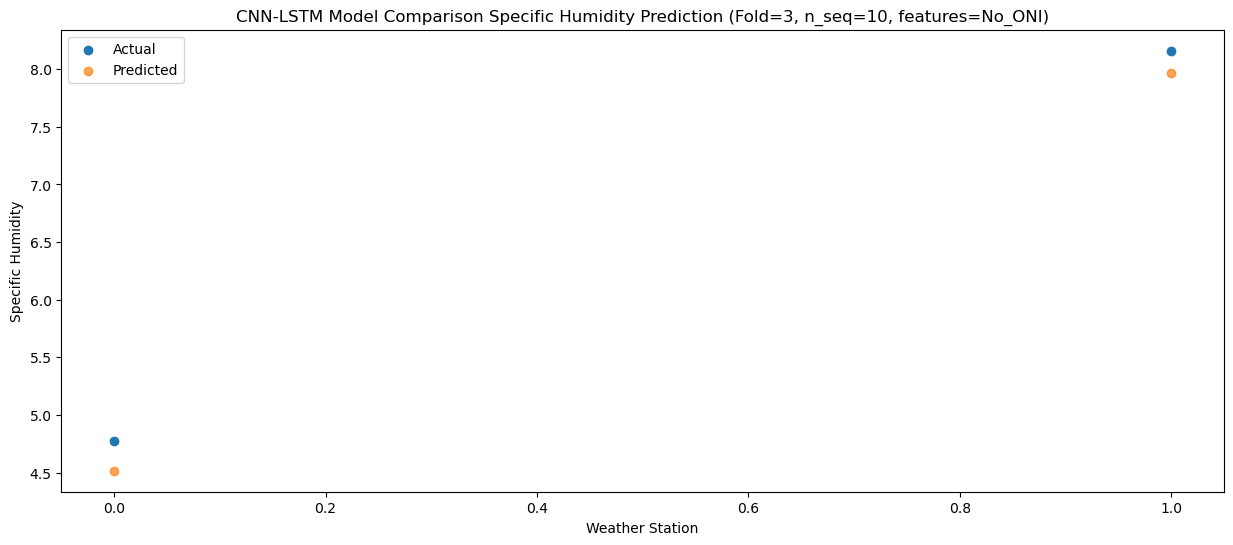

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.717166
1                1    8.18   8.161779


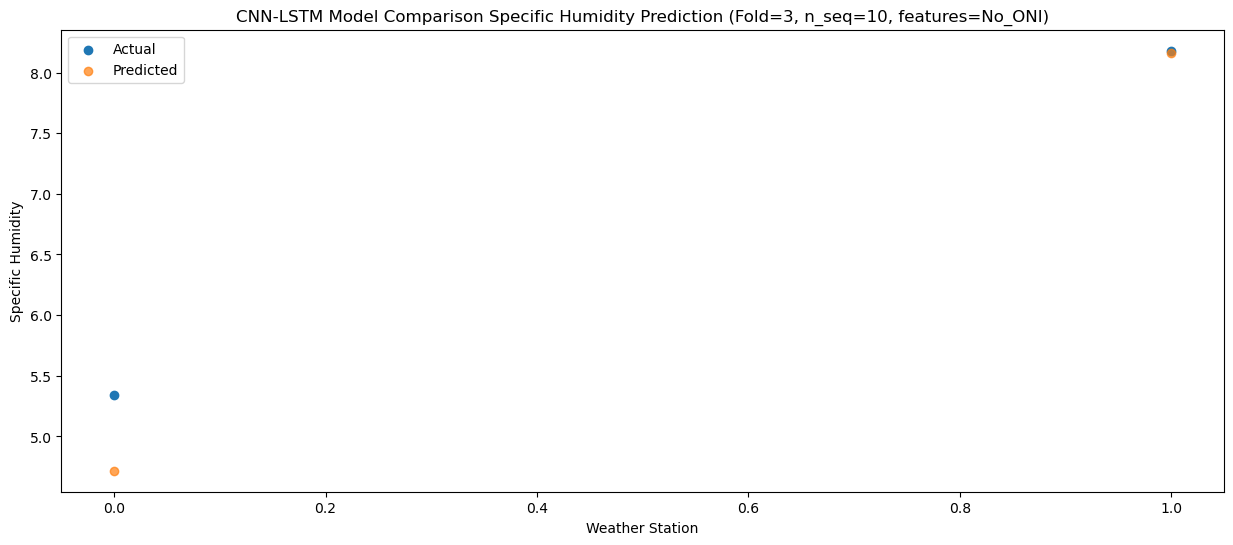

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[4.77562605 8.0299937 ]
 [5.2127565  8.59428935]
 [4.90236465 8.44732322]
 [4.98976749 8.61298676]
 [4.82375569 8.81164546]
 [4.77410942 8.41112273]
 [4.666063   8.35613567]
 [4.56531329 8.23675525]
 [4.51589716 7.96921178]
 [4.717166   8.16177891]]
Year at t+1:
t+1 SKRMSE: 0.116711
t+1 KRMSE: 0.116711
t+1 MAE: 0.112184
t+1 SKMAPE: 0.019703
t+1 R2_SCORE: 0.994065
t+1 KMAPE: 0.019703
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 0.079789
t+2 KRMSE: 0.079789
t+2 MAE: 0.058523
t+2 SKMAPE: 0.011304
t+2 R2_SCORE: 0.997909
t+2 KMAPE: 0.011304
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.173650
t+3 KRMSE: 0.173650
t+3 MAE: 0.140156
t+3 SKMAPE: 0.017772
t+3 R2_SCORE: 0.991423
t+3 KMAPE: 0.017772
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.430631
t+4 KRMSE: 0.4306

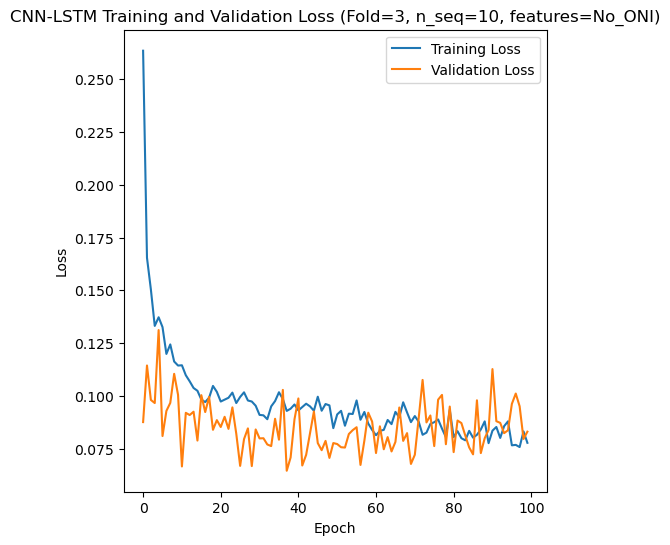

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 33s 530ms/step - loss: 0.1993 - accuracy: 0.3158 - mae: 0.1783 - rmse: 0.1993 - mape: 41.2836 - pearson: 0.1645 - val_loss: 0.1420 - val_accuracy: 0.0000e+00 - val_mae: 0.1101 - val_rmse: 0.1420 - val_mape: 26.6891 - val_pearson: 0.1615
Epoch 2/100
19/19 [==============================] - 2s 132ms/step - loss: 0.1119 - accuracy: 0.3684 - mae: 0.0883 - rmse: 0.1119 - mape: 20.6903 - pearson: 0.2082 - val_loss: 0.0998 - val_accuracy: 0.0000e+00 - val_mae: 0.0863 - val_rmse: 0.0998 - val_mape: 19.8035 - val_pearson: 0.1842
Epoch 3/100
19/19 [==============================] - 3s 135ms/step - loss: 0.0914 -

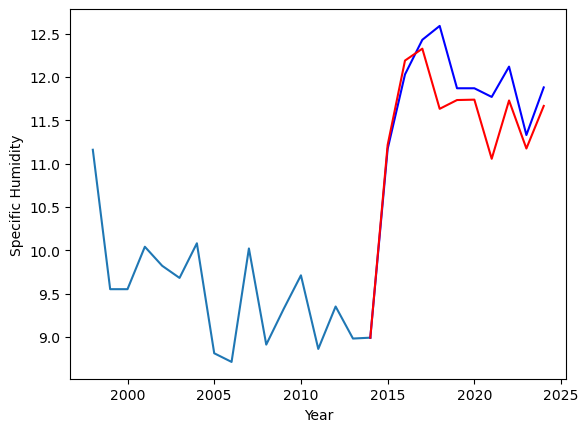

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		7.91		-0.16
8.73		8.55		-0.18
9.20		8.60		-0.60
8.87		8.39		-0.48
9.27		8.66		-0.61
8.73		8.25		-0.48
8.46		8.10		-0.36
8.79		8.30		-0.49
8.19		7.93		-0.26
8.42		8.07		-0.35


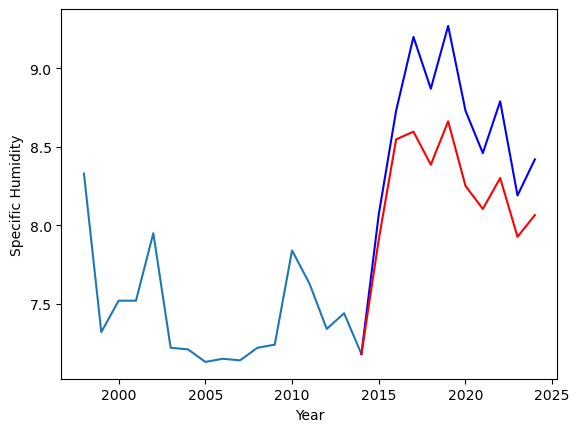

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  11.215235
1                1    8.07   7.909773


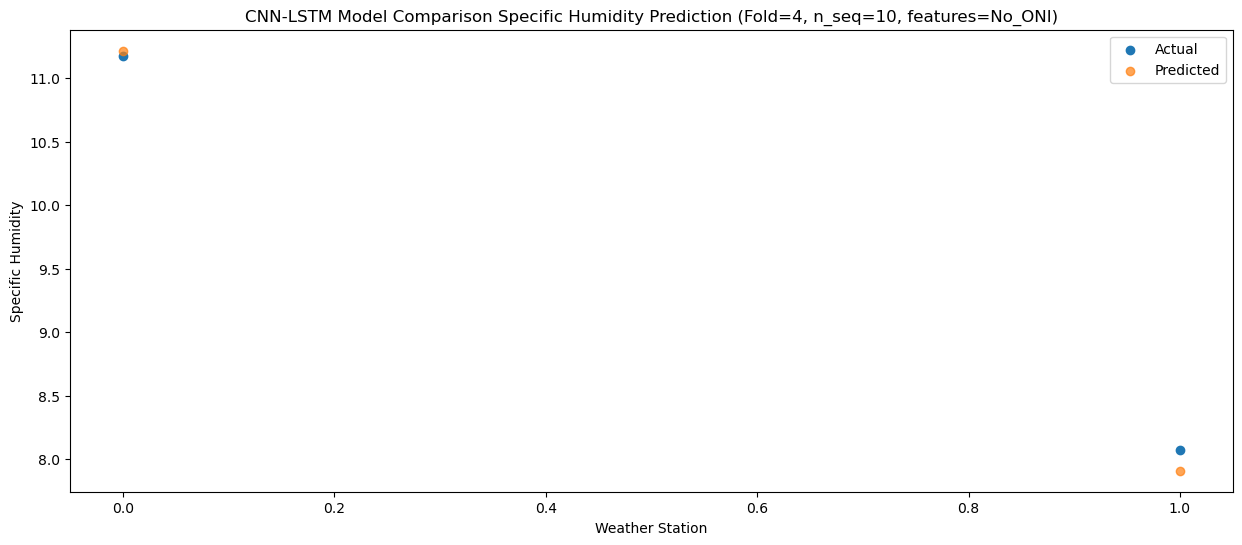

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03  12.190129
1                1    8.73   8.547464


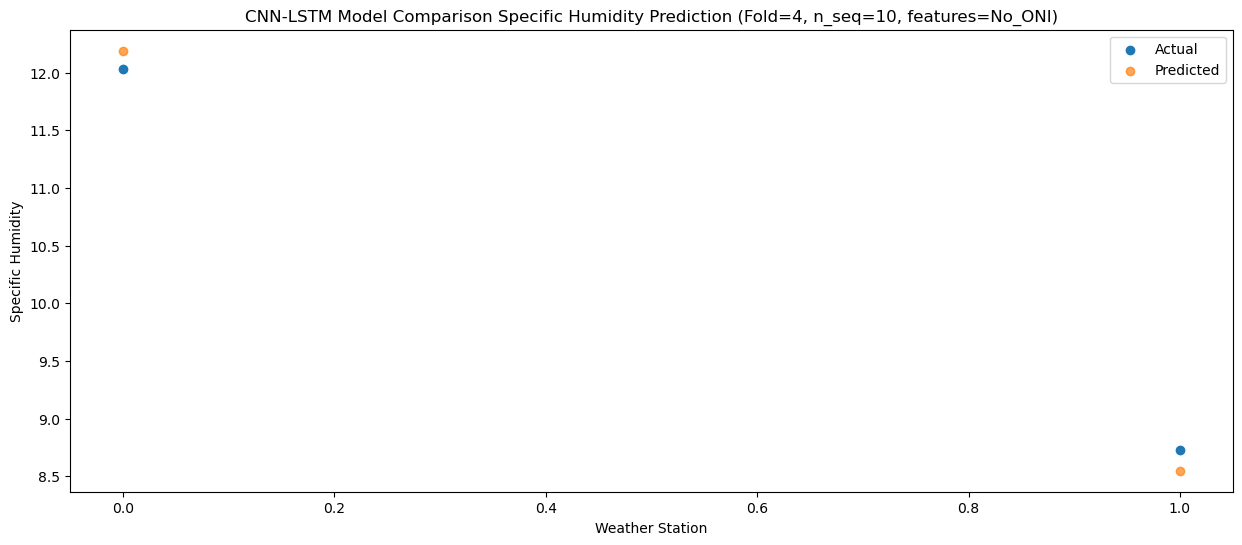

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  12.327290
1                1    9.20   8.596588


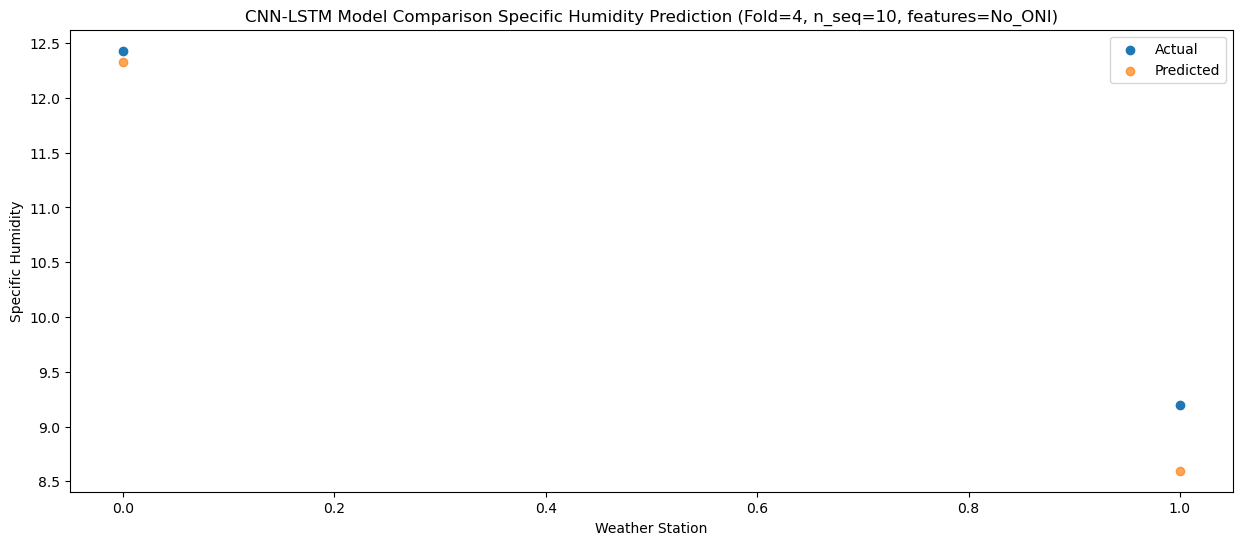

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59  11.632652
1                1    8.87   8.385939


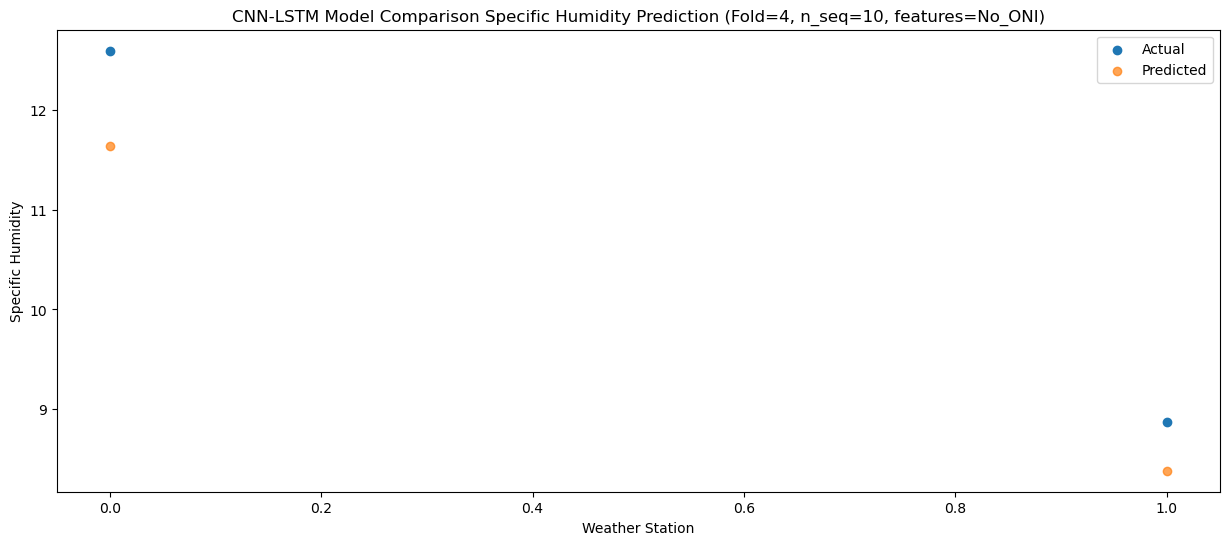

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.734094
1                1    9.27   8.662531


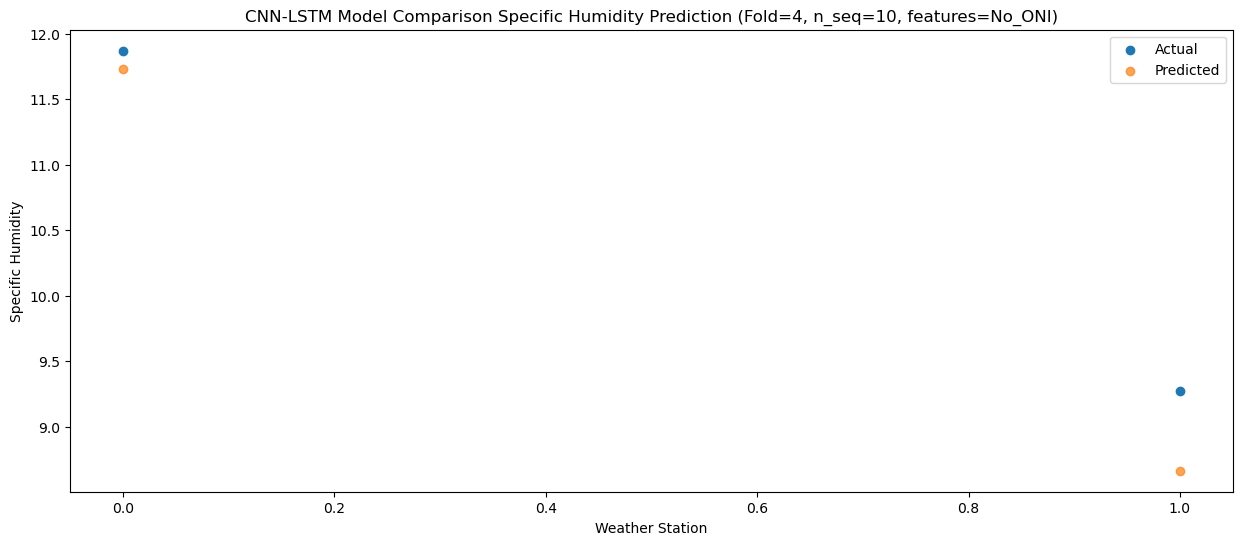

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.738655
1                1    8.73   8.251126


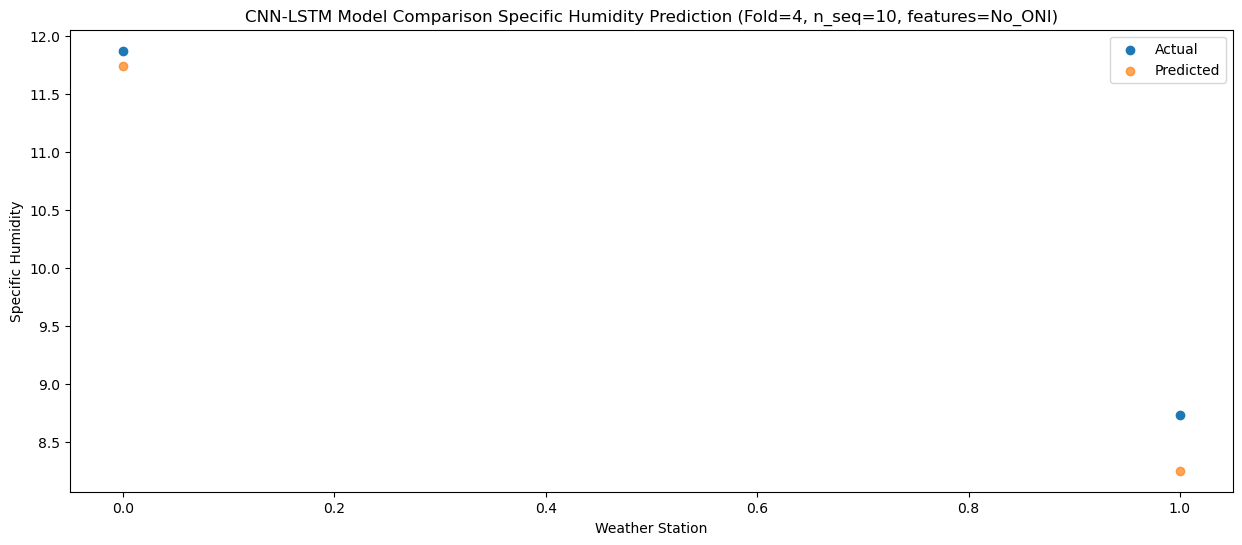

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.055818
1                1    8.46   8.104357


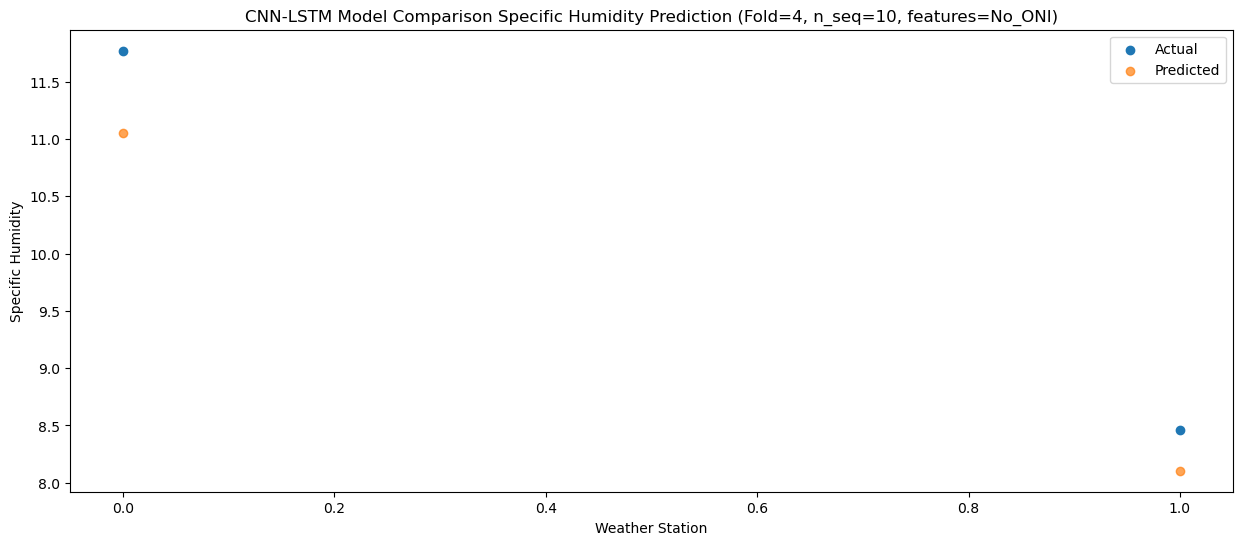

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.729103
1                1    8.79   8.301295


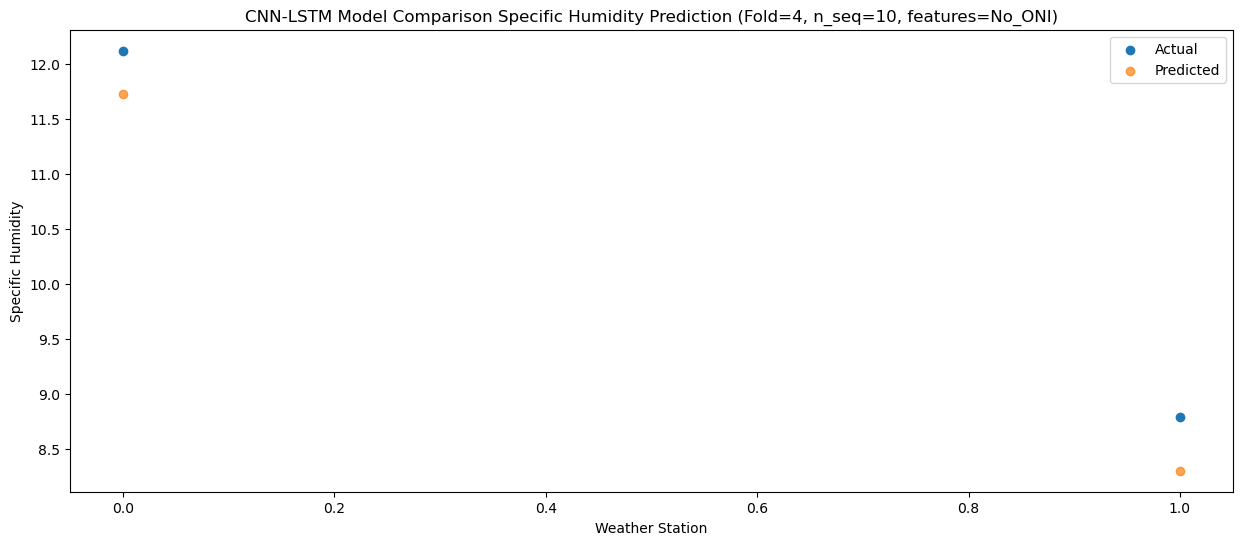

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  11.174433
1                1    8.19   7.926927


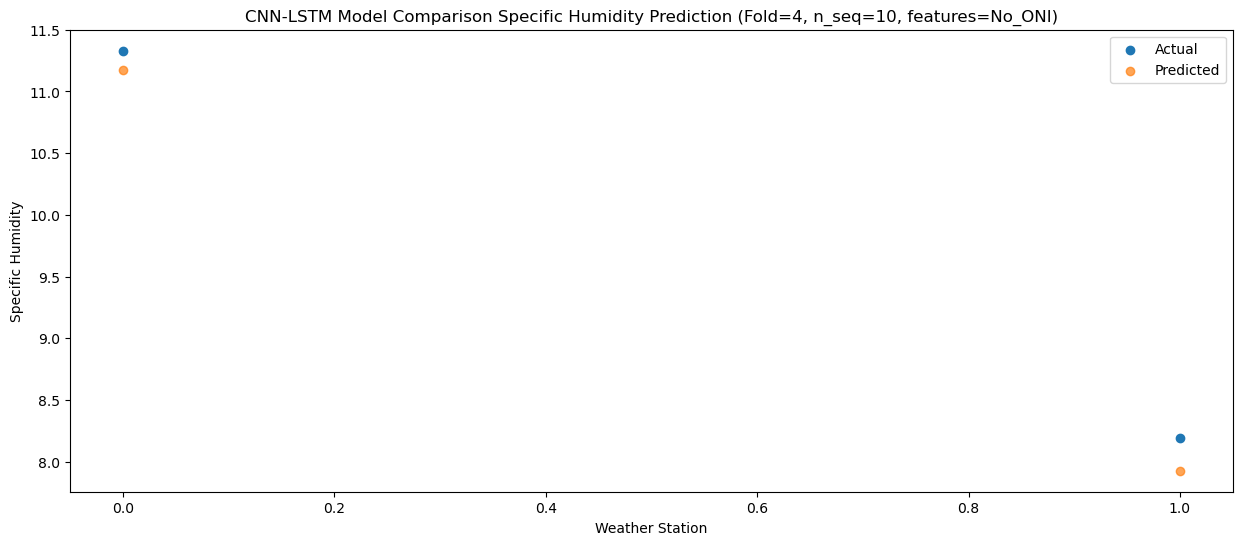

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  11.666063
1                1    8.42   8.065435


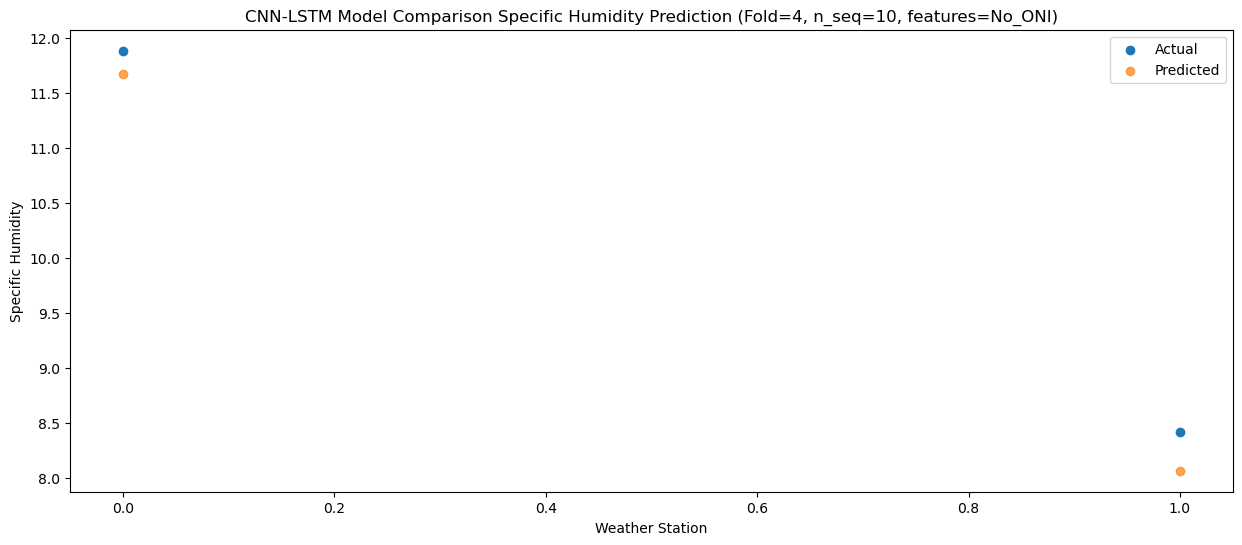

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[11.21523484  7.9097728 ]
 [12.19012889  8.54746394]
 [12.32728968  8.59658784]
 [11.63265244  8.38593893]
 [11.73409393  8.6625314 ]
 [11.73865475  8.25112625]
 [11.05581768  8.10435732]
 [11.72910281  8.30129472]
 [11.17443254  7.92692686]
 [11.66606276  8.06543491]]
Year at t+1:
t+1 SKRMSE: 0.117726
t+1 KRMSE: 0.117726
t+1 MAE: 0.102731
t+1 SKMAPE: 0.011952
t+1 R2_SCORE: 0.994231
t+1 KMAPE: 0.011952
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.171698
t+2 KRMSE: 0.171698
t+2 MAE: 0.171332
t+2 SKMAPE: 0.017110
t+2 R2_SCORE: 0.989172
t+2 KMAPE: 0.017110
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.432814
t+3 KRMSE: 0.432814
t+3 MAE: 0.353061
t+3 SKMAPE: 0.036926
t+3 R2_SCORE: 0.928178
t+3 KMAPE: 0.036926
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

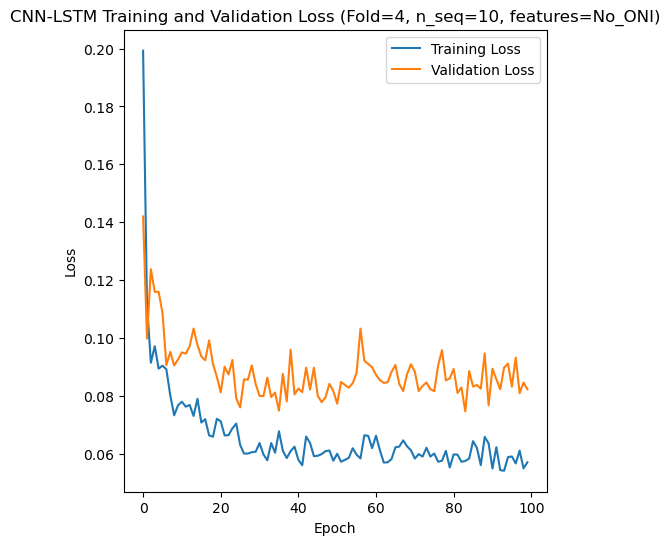

[[0.6315618541129252], [0.42972738310171443], [0.46922415263836603], [0.3843858955105543], [0.42067153178031397]]
[[array(0.63156185)], [array(0.42972738)], [array(0.46922415)], [array(0.3843859)], [array(0.42067153)]]
[[0.5608694126568741], [0.32884304798766995], [0.3819816355593504], [0.2947995272278786], [0.3492911082981146]]
[[0.04576472598598699], [0.03561085576723933], [0.039983205894308496], [0.049228661451342526], [0.03510121625466266]]
[[0.8329342064887806], [0.9493763423609264], [0.8159140892199825], [0.9475266456069671], [0.9360673726073109]]
[[array(0.04576473)], [array(0.03561086)], [array(0.03998321)], [array(0.04922866)], [array(0.03510122)]]
[[array(0.96978277)], [array(0.95753278)], [array(0.92146849)], [array(0.97921836)], [array(0.97706639)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82  8

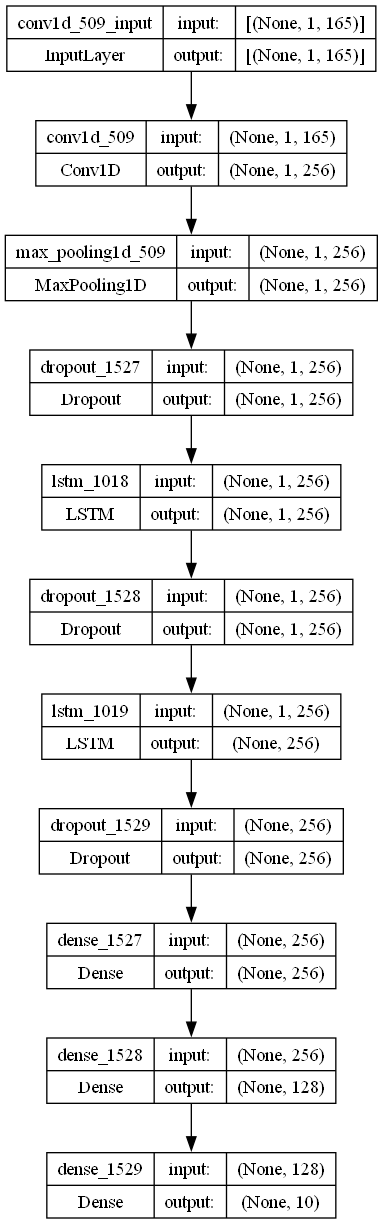

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0010366318428396447
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 256
    dropout_rate = 0.170367077582394

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S10_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)